# Research Methodology (Summary)

<p style="font-size: 2rem; background: #FFC000; color:#fff; padding: 2rem 4rem; border-radius:5px; text-align: center">
    Click on the button below to scroll to the <span style="font-weight: bold">Week 5 </span>section.</p>
    

<div style="display: flex; margin:4rem 0;">
    <div style="margin: 0 auto">
      <a type='button' href="#week4" style="border: 3px solid #ffc000; padding: 1rem 2rem; color: #ffc000; text-decoration: none; text-transform: uppercase; font-weight: bold">click here</a>
    </div>
</div>



# Data Importation

In [1]:
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import antropy as ant
import pywt
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# import the data for patient 1
dict_ = loadmat('./Class A train sets/2_EEG200908190811.mat')
dict_.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BIS', 'x', 'CH2', 'Denoised_x', 'CH2Denoised_x'])

<br/>

# Windowing

In [14]:
# Generate the windows
def generate_samples(bis, eeg, window_size=60, sampling_rate=128, verbose=False):
    """
    Generates EEG samples for consecutive windows 
    and their corresponding BIS value
    
    
    Parameters
    ----------       
    bis: (n,) array
        BIS Sample
        
    eeg: (n,) array. 
        EEG Sample. 
        
    window_size: int, default=60 
        Duration of each window in seconds
        
    sampling_rate: float default=128
        Sampling rate of the EEG sample in Hz.
        
    verbose: Bool; default=False
        Provides feedback on the sampling process
        
    
    Generates
    ---------
    tup: tuple(bis_mode, eeg_sample)
    
        bis_mode: float
            Modal BIS value of the EEG Sample
        
        eeg_sample: array
            EEG Sample for a 5 second window
        
        
        
    Example
    -------
    >>> awake = np.array([82.8])
    >>> eeg = array([ 0.17727497,  0.17783894,  0.17834346,  0.17878847,  0.17917353,
        0.17949788,  0.17976084,  0.17996202,  0.18010136,  0.18017881, ...])
       
    >>> # Create the generator
    >>> gen_sample = generate_samples(bis, eeg)
    
    >>> # Generate EEG sample
    >>> sample = next(gen_sample)
    
    
    Notes
    -----
    generate_samples works well with the generate_DFTParameters and generate_DWTParameters functions.
    
    >>> generate_DFTParameters(sample)
    [0.075986      0.206614     0.405465      1.290984      0.980829       84.5]
    
    """
    
    bis_len = len(bis)
    
    if bis_len < window_size:
        print("Length of BIS values must be greater than {}".format(window_size))
        return    

    
    start, end = 0, window_size
    
    eeg_start, eeg_end = 0, end * sampling_rate
    
    
    while True:
        if end > bis_len:
            break
        
        bis_idx = bis[start:end][-1][0]
        
        eeg_sample = eeg[eeg_start:eeg_end]
        
        data = namedtuple('EEG_Sample', ['eeg', 'bis'])
        
        tup = data(eeg_sample, bis_idx)
        
        if verbose:
            print("EEG Start: {} - {}".format(eeg_start, eeg_end))
        
        yield tup
        
        # update ranges
        start += 1
        end += 1
        
        eeg_start = start * sampling_rate
        eeg_end = end * sampling_rate
        
        


    

<br/>

## Testing <code>generate_samples</code>

We have to make sure that 60th BIS value for this patient - **82.9**, is the first value generated by the generator.

In [15]:
# -----
# TEST
# -----

# Get the data
bis = dict_.get('BIS')
eeg_sample = np.ravel(dict_.get('CH2Denoised_x'))

# Create the generator
test_generator = generate_samples(bis, eeg_sample, verbose=True)

test_sample = next(test_generator)

print("First BIS index: ", test_sample.bis)

# Check that BIS values are only recorded after 60 seconds
# The 60th BIS is 82.9 for this patient
assert test_sample.bis == bis[59] == 82.9

EEG Start: 0 - 7680
First BIS index:  82.9


<br/>

# Feature Extraction

## DFT <code>generate_DFTParameters</code>

In [16]:
def generate_DFTParameters(eeg_sample, sampling_rate=128, method="samp_ent"):
    """
    Generate the DFT parameters of EEG segments
    
    
    Parameters
    ----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        eeg: (n,) array 
            EEG Data
            
        bis: float
            Bispectral Index
            
        
    sampling_rate: int
        Sampling rate of the EEG segment
    
    
    method: String; default="samp_ent"; Values can be "samp_ent", "perm_ent", "hig", or "katz"
    
        Feature extraction methods implemented here are 
        - Sample entropy
        - Permutation entropy
        - Higuchi's Fractal Dimension
        - Katz's Fractal Dimension
        
        
        
    Returns
    -------
    df : namedtuple
        namedtuple of EEG parameters
        
    
    Notes
    -----
    Works well with the generate_samples function. See the documentation on generate_samples.
    """
    
    # amplitudes
    fft_values = np.absolute(np.fft.rfft(eeg_sample.eeg))

    # frequencies
    fft_freq = np.fft.rfftfreq(len(eeg_sample.eeg), 1.0/sampling_rate)
    
    # Analysing the bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    eeg_band_fft = dict()

    for band in eeg_bands.keys():
        freq_idx = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))

        # sum the amplitudes of the bands
        eeg_band_fft[band] = fft_values[freq_idx]
        

    # Sample entropy
    if method == "samp_ent":
        # Sample entropy of the delta band
        sampen_delta = ant.sample_entropy(eeg_band_fft['Delta'])
        sampen_beta = ant.sample_entropy(eeg_band_fft['Beta'])
        sampen_theta = ant.sample_entropy(eeg_band_fft['Theta'])
        sampen_gamma = ant.sample_entropy(eeg_band_fft['Gamma'])
        sampen_alpha = ant.sample_entropy(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"])

        return Parameters(sampen_delta, sampen_beta, sampen_theta, sampen_gamma, sampen_alpha, eeg_sample.bis)


    # Normalized Permutation Entropy
    if method == "perm_ent":
        permen_delta = ant.perm_entropy(eeg_band_fft['Delta'], normalize=True)
        permen_beta = ant.perm_entropy(eeg_band_fft['Beta'], normalize=True)
        permen_theta = ant.perm_entropy(eeg_band_fft['Theta'], normalize=True)
        permen_gamma = ant.perm_entropy(eeg_band_fft['Gamma'], normalize=True)
        permen_alpha = ant.perm_entropy(eeg_band_fft['Alpha'], normalize=True)

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Permen_Delta", "Permen_Beta", "Permen_Theta", "Permen_Gamma", "Permen_Alpha", "BIS"])

        return Parameters(permen_delta, permen_beta, permen_theta, permen_gamma, permen_alpha, eeg_sample.bis)


    # Higuchi Fractal Dimension
    if method == "hig":
        hig_delta = ant.higuchi_fd(eeg_band_fft['Delta'])
        hig_beta = ant.higuchi_fd(eeg_band_fft['Beta'])
        hig_theta = ant.higuchi_fd(eeg_band_fft['Theta'])
        hig_gamma = ant.higuchi_fd(eeg_band_fft['Gamma'])
        hig_alpha = ant.higuchi_fd(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Hig_Delta", "Hig_Beta", "Hig_Theta", "Hig_Gamma", "Hig_Alpha", "BIS"])

        return Parameters(hig_delta, hig_beta, hig_theta, hig_gamma, hig_alpha, eeg_sample.bis)


    # Katz Fractal Dimension
    if method == "katz":
        # Sample entropy of the delta band
        katz_delta = ant.katz_fd(eeg_band_fft['Delta'])
        katz_beta = ant.katz_fd(eeg_band_fft['Beta'])
        katz_theta = ant.katz_fd(eeg_band_fft['Theta'])
        katz_gamma = ant.katz_fd(eeg_band_fft['Gamma'])
        katz_alpha = ant.katz_fd(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Katz_Delta", "Katz_Beta", "Katz_Theta", "Katz_Gamma", "Katz_Alpha", "BIS"])

        return Parameters(katz_delta, katz_beta, katz_theta, katz_gamma, katz_alpha, eeg_sample.bis)
    
    
    # All parameters
    if method == "all":
        # Let's hope we never have to do this
        pass
    

<br/>

## DWT <code>generate_DWTParameters</code>

In [17]:
def generate_DWTParameters(eeg_sample, wavelet="db4", method="samp_ent"):
    
    """
    Generate the DWT Parameters of an EEG Sample
    
    
    Parameters
    -----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        bis: float
            Bispectral Index
            
        eeg: (n,) array 
            EEG Data
            
            
    wavelet: String; default="db4"
        Wavelet to use
    
    
    method: String; default="samp_ent"; Values can be "samp_ent", "perm_ent", "hig", or "katz"
    
        Feature extraction method: Methods implemented here are 
        - Sample entropy
        - Permutation entropy
        - Higuchi's Fractal Dimension
        - Katz's Fractal Dimension
        
        
        
    Returns
    -------
    df : namedtuple
        namedtuple of EEG parameters
        
    
    Notes
    -----
    Works well with the generate_samples function. See the documentation on generate_samples.
    """
    
    # Approximate and Detailed Coefficients
    cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(eeg_sample.eeg, wavelet, level=4)
    
    
    # Introduced a new method parameter: The parameters are calculated based on the method selected
    if method == "samp_ent":
        # Sample Entropy of the sub-bands
        sampen_cA_4 = ant.sample_entropy(cA_4)
        sampen_cD_4 = ant.sample_entropy(cD_4)
        sampen_cD_3 = ant.sample_entropy(cD_3)
        sampen_cD_2 = ant.sample_entropy(cD_2)
        sampen_cD_1 = ant.sample_entropy(cD_1)

        # Create the namedtuple 
        Parameters = namedtuple('Parameters', ["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"])

        return Parameters(sampen_cA_4, sampen_cD_4, sampen_cD_3, sampen_cD_2, sampen_cD_1, eeg_sample.bis)
        
        
    # Normalized Permutation Entropy: variables -> order, delay, normalize
    # Use default values in the meantime
    if method == "perm_ent":
        perment_cA_4 = ant.perm_entropy(cA_4, normalize=True)
        perment_cD_4 = ant.perm_entropy(cD_4, normalize=True)
        perment_cD_3 = ant.perm_entropy(cD_3, normalize=True)
        perment_cD_2 = ant.perm_entropy(cD_2, normalize=True)
        perment_cD_1 = ant.perm_entropy(cD_1, normalize=True)

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ['Permen_cA_4', 'Permen_cD_4', 'Permen_cD_3', 'Permen_cD_2', 'Permen_cD_1', 'BIS'])

        return Parameters(perment_cA_4, perment_cD_4, perment_cD_3, perment_cD_2, perment_cD_1, eeg_sample.bis)
        
        
    # Higuchi's Fractal Dimension: variable -> kmax
    # Use default value in the meantime
    if method == "hig":        
        hig_cA_4 = ant.higuchi_fd(cA_4)
        hig_cD_4 = ant.higuchi_fd(cD_4)
        hig_cD_3 = ant.higuchi_fd(cD_3)
        hig_cD_2 = ant.higuchi_fd(cD_2)
        hig_cD_1 = ant.higuchi_fd(cD_1)

        
        # Create the namedtuple
        Parameters = namedtuple('Parameters', ['Hig_cA_4', 'Hig_cD_4', 'Hig_cD_3', 'Hig_cD_2', 'Hig_cD_1', 'BIS'])

        return Parameters(hig_cA_4, hig_cD_4, hig_cD_3, hig_cD_2, hig_cD_1, eeg_sample.bis)
        
        
    # Katz Fractal Dimension        
    if method == "katz":
        katz_cA_4 = ant.katz_fd(cA_4)
        katz_cD_4 = ant.katz_fd(cD_4)
        katz_cD_3 = ant.katz_fd(cD_3)
        katz_cD_2 = ant.katz_fd(cD_2)
        katz_cD_1 = ant.katz_fd(cD_1)

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ['Katz_cA_4', 'Katz_cD_4', 'Katz_cD_3', 'Katz_cD_2', 'Katz_cD_1', 'BIS'])

        return Parameters(katz_cA_4, katz_cD_4, katz_cD_3, katz_cD_2, katz_cD_1, eeg_sample.bis)
    
    # All parameters
    if method == "all":
        # Let's hope we never have to do this
        pass

<br/>

# Dataset Creation

In this section, the essential functions - <code>generate_samples</code>, <code>generate_DFTParameters</code>, and <code>generate_DWTParameters</code> are tested in the creation of the DFT and DWT datasets.

## DFT

In [23]:
# -----
# TEST
# -----
bis = dict_.get('BIS')
denoised = dict_.get('CH2Denoised_x')

# Generator that creates EEG samples: Read the docs if anything goes wrong
test_gen = generate_samples(bis, np.ravel(denoised))

# Generate the dataset: Use the permutation entropy
df_dft = pd.DataFrame(data=[generate_DFTParameters(sample, method="perm_ent") for sample in test_gen])

# Modify index
df_dft.index = df_dft.index + 60

df_dft.head()

Permen_Delta  Permen_Beta  Permen_Theta  Permen_Gamma  Permen_Alpha   BIS
60      0.988067     0.998627      0.998289      0.989929      0.996390  82.9
61      0.993100     0.998845      0.997055      0.994432      0.998635  83.1
62      0.990133     0.999172      0.996116      0.993018      0.998130  83.1
63      0.995129     0.999353      0.996467      0.992290      0.998329  83.1
64      0.995239     0.999206      0.997822      0.994540      0.998514  83.2

<br/>

## DWT

In [22]:
# -----
# TEST
# -----

# The data
bis = dict_.get('BIS')
denoised = dict_.get('CH2Denoised_x')

# Generator that creates EEG samples: Read the docs if anything goes wrong
test_gen = generate_samples(bis, np.ravel(denoised))

# Creating the dataset
dwt_dataset = [generate_DWTParameters(sample, method="perm_ent") for sample in test_gen]

# Dataset
df_dwt = pd.DataFrame(data=dwt_dataset)

# Modify index
df_dwt.index = df_dwt.index + 60

df_dwt.head()


Permen_cA_4  Permen_cD_4  Permen_cD_3  Permen_cD_2  Permen_cD_1   BIS
60     0.909313     0.998170     0.998410     0.998466     0.999824  82.9
61     0.910142     0.998763     0.998607     0.998399     0.999777  83.1
62     0.914953     0.998570     0.998681     0.998213     0.999741  83.1
63     0.916504     0.998376     0.999089     0.997598     0.999704  83.1
64     0.917896     0.997956     0.998860     0.996974     0.999402  83.2

<br/>

<div id="week4"></div>

# Week 5 Tasks

In this week, we want to research about the Permutation entropy method to learn the parameters commonly used for depth of anesthesia estimation using EEG signals. We also want to use the 4 methods on Power Spectral Density(PSD) 
of both the denoised and original EEG Signals.

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem; margin: 3rem 0;">
    <h2 style="margin: 0; color: #343d52;">Permutation Entropy</h2>
    <p>Check out the parameters used to calculate the normalized Permutation entropy in EEG Analysis ($\tau$ and $m$). Relevant research papers are perused to learn the paramaters of the permutation entropy method for DoA with EEG.</p>
    

<br>

<table style="font-size: 1.5rem;">
    <tr>
        <th>Paper</th>
        <th>Parameters</th>
    </tr>
    <tr>
        <td><a href="https://www.mdpi.com/1424-8220/19/11/2499">Use of Multiple EEG Features and Artificial Neural Network to Monitor the Depth of Anesthesia</a></td>
        <td>$\tau$ = 1, $m$ = 3.</td>
    </tr>
    <tr>
        <td><a href="https://www.frontiersin.org/articles/10.3389/fnins.2020.00026/full">Monitoring Depth of Anesthesia Based on Hybrid Features and Recurrent Neural Network</a></td>
        <td>$\tau$ = 1, $m$ = 4.</td>
    </tr>
    <tr>
        <td><a href="https://ieeexplore.ieee.org/document/7935360">Monitoring the Depth of Anesthesia Using a New Adaptive Neurofuzzy System</a></td>
        <td>$\tau$ = 1, $m$ = 6.</td>
    </tr>
    
</table>


We will set ```normalize=True``` to compute the **normalized** Permutation Entropy value. We did not do that in Week 4. This could potentially improve our results. Thus, the dataset created using the Permutation Entropy method will be recreated using the normalized values.
</div>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem; margin: 3rem 0;">
    <h2 style="margin: 0; color: #343d52">Transform the data</h2>
    <p>For this week, we want to try using the squared values of the denoised EEG signals, and the denoised EEG signals recorded from channel 2. This involves the use of <code>CH2_Denoised</code> and <code>CH2</code>.</p>
</div>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem; margin: 3rem 0;">
    <h2 style="margin: 0; color: #343d52">Perform Feature Selection</h2>
    <p>Repeat the analysis from week 3 and week 4, and select the best features for DoA estimation based on each method.</p>
</div>

<br/>

## The  <code>visualise_params</code> function

In [5]:
# Training set
import os
training_set = [file for file in os.listdir("./Class A train sets") if ".mat" in file]

In [6]:
training_set

['31_EEG200909092.mat',
 '14_EEG200906220903.mat',
 '4_EEG200909160908.mat',
 '13_EEG20100609.mat',
 '19_EEG201004072.mat',
 '30_EEG200909091.mat',
 '2_EEG200908190811.mat',
 '32_EEG201004071.mat',
 '20_EEG201005241.mat',
 '7_EEG201005241657.mat',
 '3_EEG200908190921.mat']

In [7]:
# HELPER FUNCTION
def plot_graph(df_dft, df_dwt, graph_type=None):

    if graph_type == None:
        fig, ax = plt.subplots(2, 6, figsize=(30,10))
        
        # Modifying columns
        dft_columns = df_dft.columns
        dwt_columns = df_dwt.columns


        # Plot DFT data
        for j in range(6):
            ax[0,j].plot(df_dft[dft_columns[j]])
            ax[0,j].set_xlabel("Samples")
            ax[0,j].set_ylabel(dft_columns[j])


        # Plot DWT data
        for i in range(6):
            if i == 5:
                ax[1,i].axis("off")
                break

            ax[1,i].plot(df_dwt[dwt_columns[i]])
            ax[1,i].set_xlabel("Samples")
            ax[1,i].set_ylabel(dwt_columns[i])



        plt.show()
        
        
    if graph_type == "scatter":
        fig, ax = plt.subplots(2, 6, figsize=(30,10))
        # Modifying columns
        dft_columns = df_dft.columns
        dwt_columns = df_dwt.columns


        # Plot DFT data
        for j in range(6):
            
            if j == 5:
                ax[0,j].plot(df_dft[dft_columns[j]])
                ax[0,j].set_xlabel("Samples")
                ax[0,j].set_ylabel("BIS")
                break
            
            ax[0,j].scatter(df_dft[dft_columns[j]], df_dft['BIS'])
            ax[0,j].set_xlabel(dft_columns[j])
            ax[0,j].set_ylabel("BIS")


        # Plot DWT data
        for i in range(6):
            if i == 5:
                ax[1,i].axis("off")
                break

            ax[1,i].scatter(df_dwt[dwt_columns[i]], df_dft['BIS'])
            ax[1,i].set_xlabel(dwt_columns[i])
            ax[1,i].set_ylabel("BIS")



        plt.show()
    

<br/>

In [8]:
# More helper functions
def concat_files(test_file, folder=None):
    
    try:
        conc = pd.read_csv("./Class A train sets/{}/Modified/{}_modified.csv".format(folder, test_file))
        return;
        
    except FileNotFoundError:
        if folder == None:
            print("Please enter a directory to store the data")
            return    

        print("Concatenating the data to create 10-feature dataset...")
        
        # read in the dft and dwt data of the patient
        df_dft = pd.read_csv("./Class A train sets/{}/{}_DFT.csv".format(folder, test_file))
        df_dwt = pd.read_csv("./Class A train sets/{}/{}_DWT.csv".format(folder, test_file))

        # drop one of the bis columns
        df_dft.drop('BIS', inplace=True, axis=1)

        conc = pd.concat([df_dft, df_dwt], axis=1)

        conc.to_csv("./Class A train sets/{}/Modified/{}_modified.csv".format(folder, test_file), index=False)
        
        print("Done Concatenating")

In [21]:
# TEST: Run this after all visualisations
for file in training_set:
    concat_files(file, folder="PermEntropy")

<br/>

In [10]:
# Run this after concat_files
def consolidate_files(training_files, folder=None):
    try:
        data_csv = pd.read_csv("./Class A train sets/{}/Modified/data.csv".format(folder))
        return;
    except:
        if folder == None:
            print("Please enter a directory to store the data")
            return
        
        print("Consolidating the files to create data.csv")

        df = pd.concat([pd.read_csv("./Class A train sets/{}/Modified/{}_modified.csv".format(folder, file)) for file in training_files])
        df.to_csv("./Class A train sets/{}/Modified/data.csv".format(folder), index=False)
        
        print("Done Saving!")
        

In [136]:
# TEST: Consolidate the files in the PermEntropy folder
consolidate_files(training_set, folder="PermEntropy")

<br/>

In [11]:
def visualise_params(training_file, folder=None, graph_type=None, method="samp_ent"):
    
    """
    Make line and scatterplots as discussed with Dr. Li.
    
    
    Parameters
    ----------
    training_file: str
        The matlab file containing the EEG data
        
    
    folder: str, default None
        The directory to store the files in.
        
        
    graph_type: str, default None
        If graph_type is None, a line graph is plotted but if graph_type is 'scatter',
        a scatter plot of the BIS against each parameter is created.
        
        
    method: String; default = "samp_ent"
        Values can be "samp_ent", "perm_ent", "hig", "katz". 
        See the documentation on the generate_DFTParameters or generate_DWTParameters function.
        
        
        
    Notes
    ------
    The visualise_params functions also stores the data it visualises if the data does not exist. This is 
    why a directory has to be specified.
        
    """
    
    if folder == None:
        print("Please enter a directory to store your data")
        
        return;
    
    # Load processed data if it exists
    try:
        df_dft = pd.read_csv("Class A train sets/{}/{}_DFT.csv".format(folder, training_file))
        dwt_dft = pd.read_csv("Class A train sets/{}/{}_DWT.csv".format(folder, training_file))
        
        plot_graph(df_dft, dwt_dft, graph_type)
        
        
    except:
        
        # Load the data from the file
        dict_ = loadmat('./Class A train sets/{}'.format(training_file))

        # Extract relevant data
        bis = dict_.get('BIS')
        eeg_sample = np.ravel(dict_.get('CH2Denoised_x'))
        
        # ---------------------
        # WEEK 5: MODIFICATION 
        # ---------------------
        eeg_sample = np.square(eeg_sample)

        # Generate EEG samples from the data
        gen_dft = generate_samples(bis, eeg_sample)

        # DFT data
        dft_dataset = [generate_DFTParameters(sample, method=method) for sample in gen_dft]

        # Generate EEG samples from the data
        gen_dwt = generate_samples(bis, eeg_sample)

        # DWT data
        dwt_dataset = [generate_DWTParameters(sample, method=method) for sample in gen_dwt]

        # Create dataset
        df_dft = pd.DataFrame(data=dft_dataset)
        df_dwt = pd.DataFrame(data=dwt_dataset)

        # Reset their indexes
        df_dft.index = df_dft.index + 60
        df_dwt.index = df_dwt.index + 60

        # Save the data for future use
        print("Saving dataset for future use")
        print()
        df_dft.to_csv("./Class A train sets/{}/{}_DFT.csv".format(folder, training_file), index=False)
        df_dwt.to_csv("./Class A train sets/{}/{}_DWT.csv".format(folder, training_file), index=False)
        


        # Plotting the data
        print("Making relevant graphs for Patient {}".format(training_file))
        print("-------------------------------------------------------")


        plot_graph(df_dft, df_dwt, graph_type)
        

<br/>

<p style="font-size: 2rem; font-weight:bold; margin: 1rem 0">The DFT and DWT data for each patient is saved after processing as shown in the figure below.</p>

<img src="ProcessedImg.png" >

<br/>

## Visualisation function: Using <code>visualise_params</code>

In addition to data visualisation, this function saves the **DFT** and **DWT** data of each patient. It also creates a 10-feature dataset from the data. Lastly, it merges the 10-feature data of each patient into one file called ```data.csv```. The modified files are stored in the ```Modified``` folder.

In [12]:
## Visualisations for all patients
def visualise(training_set, method, folder):
    for patient in training_set:
        print("File: {}".format(patient))
        print()
        print("A plot of the Parameters")
        print("--------------------------")
        visualise_params(patient, folder=folder, method=method)
        print("BIS against each parameter")
        print("--------------------------")
        visualise_params(patient, folder=folder, graph_type='scatter', method=method)
        print()
        print()
        
        concat_files(patient, folder=folder)

    consolidate_files(training_set, folder=folder)


Folder: PermEntropy, Method: perm_ent
File: 31_EEG200909092.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 31_EEG200909092.mat
-------------------------------------------------------


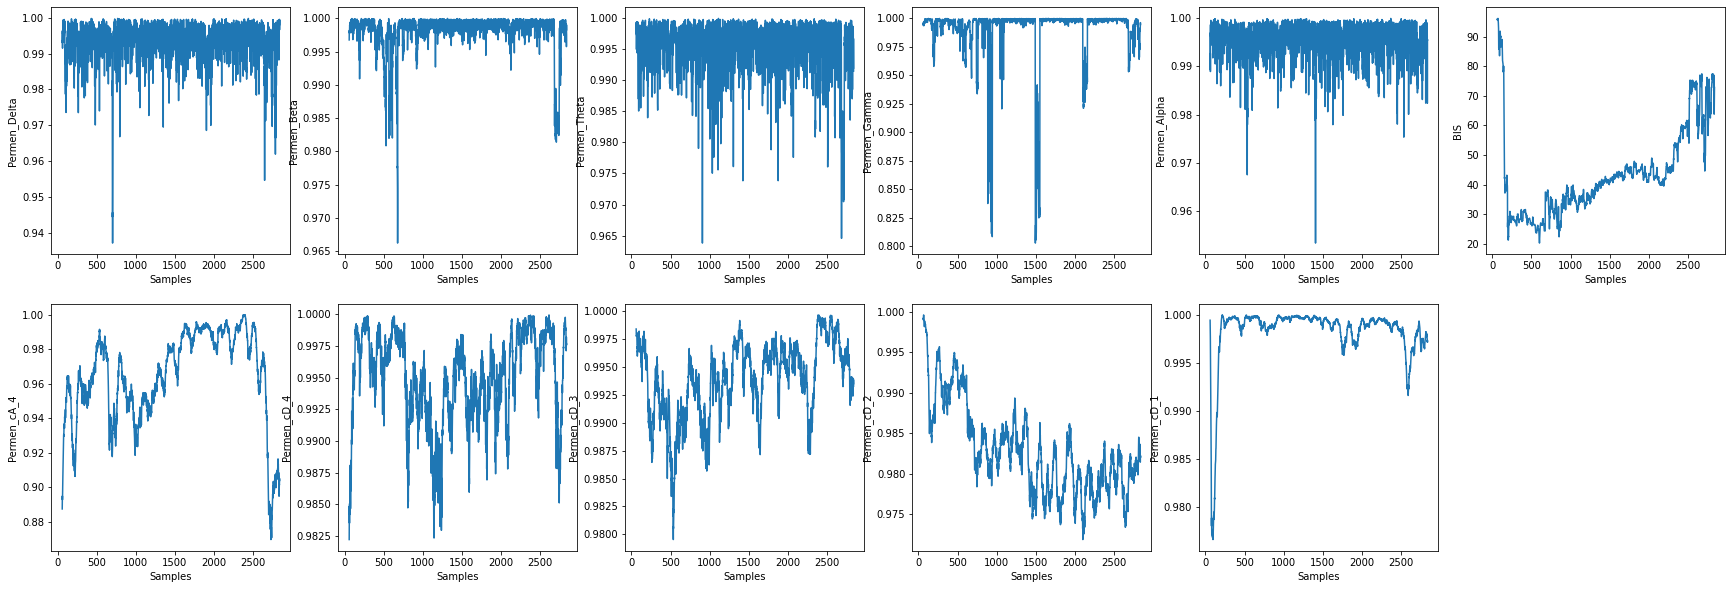

BIS against each parameter
--------------------------


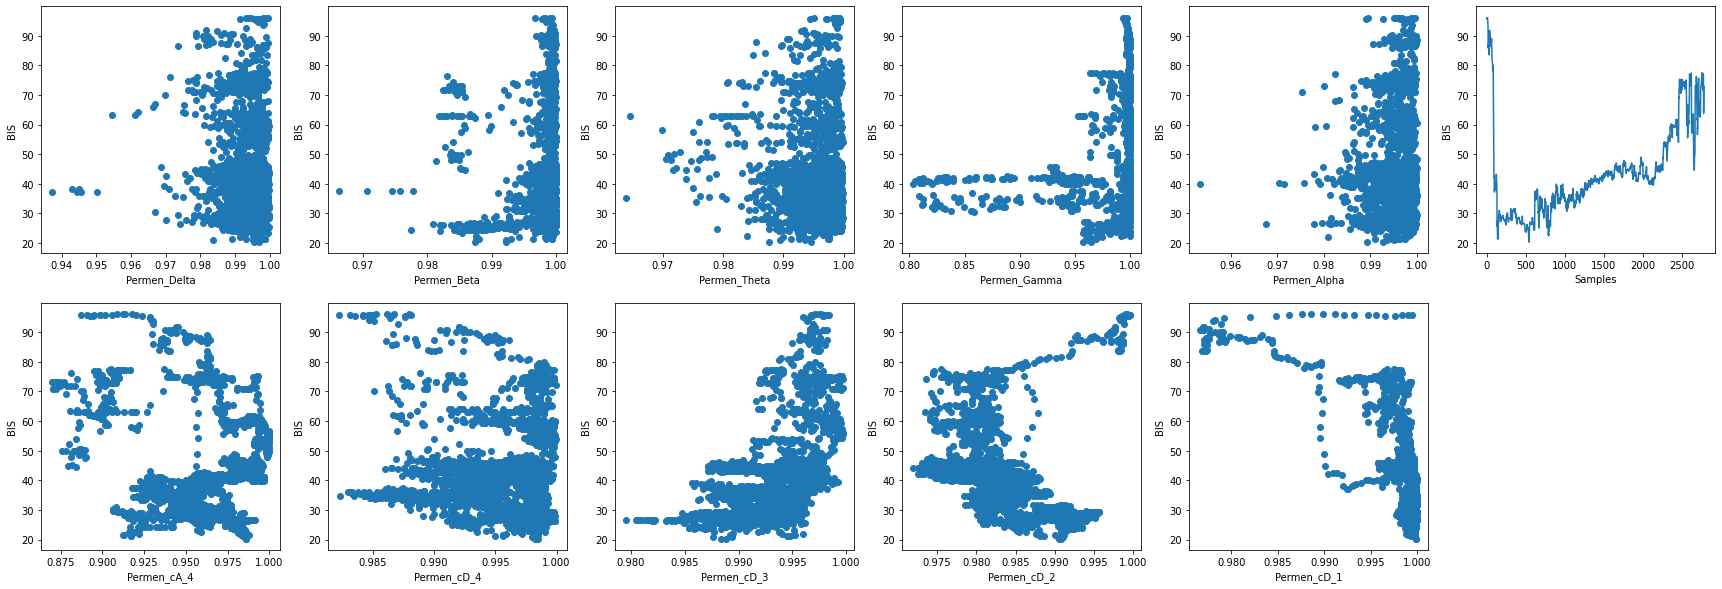



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 14_EEG200906220903.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 14_EEG200906220903.mat
-------------------------------------------------------


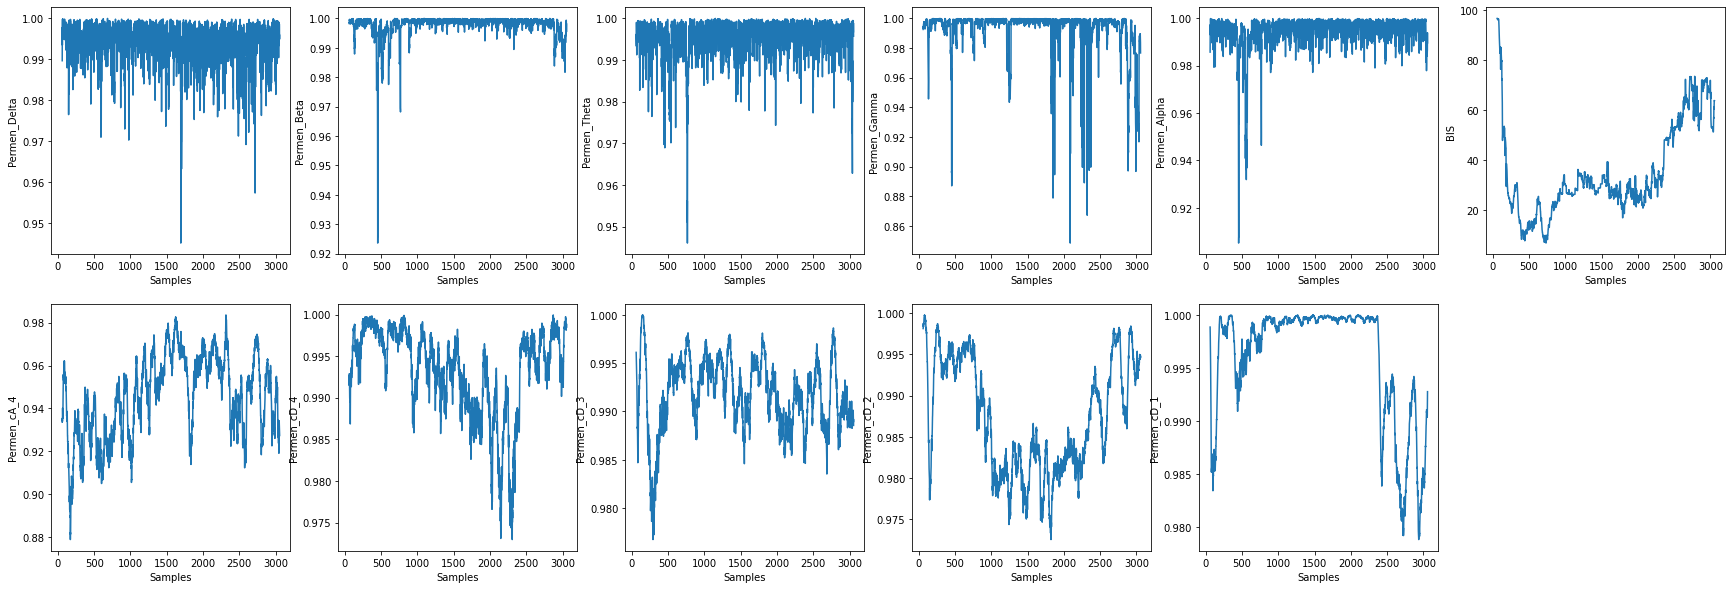

BIS against each parameter
--------------------------


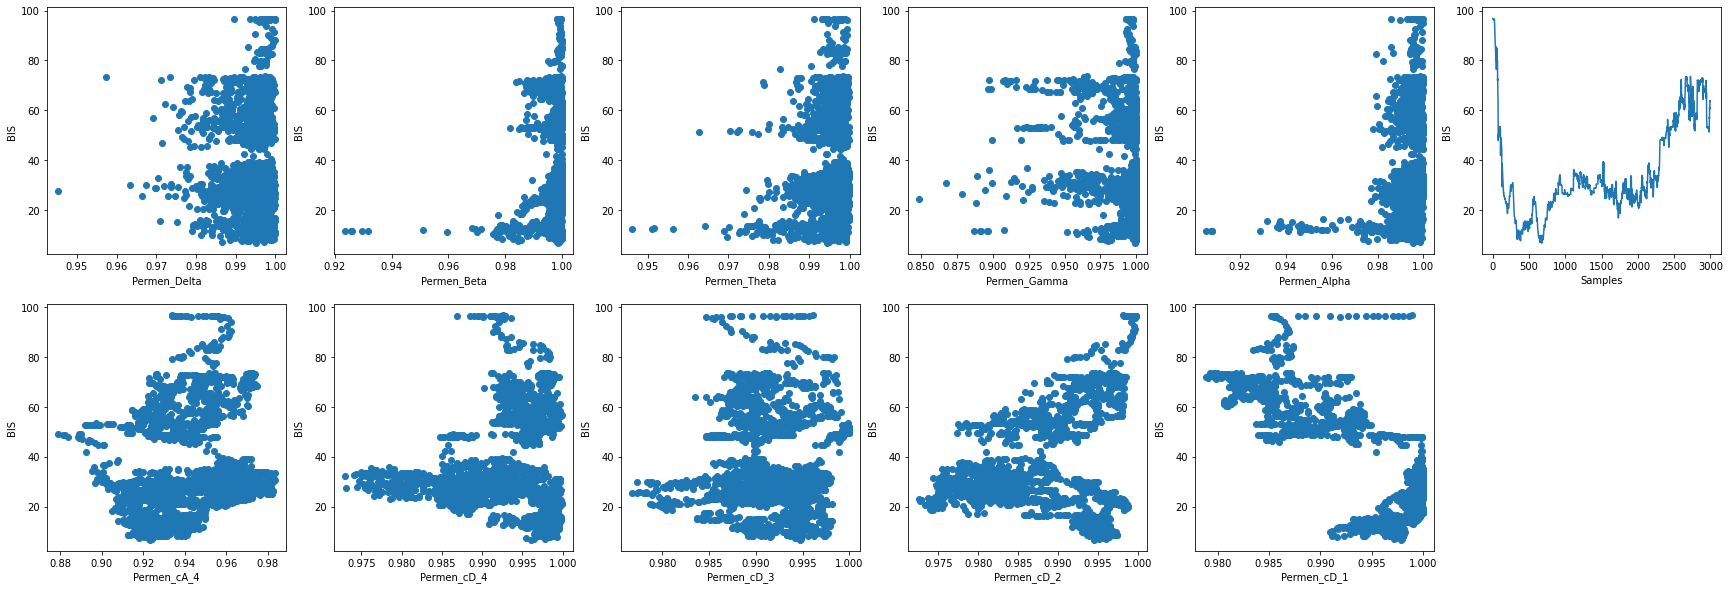



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 4_EEG200909160908.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 4_EEG200909160908.mat
-------------------------------------------------------


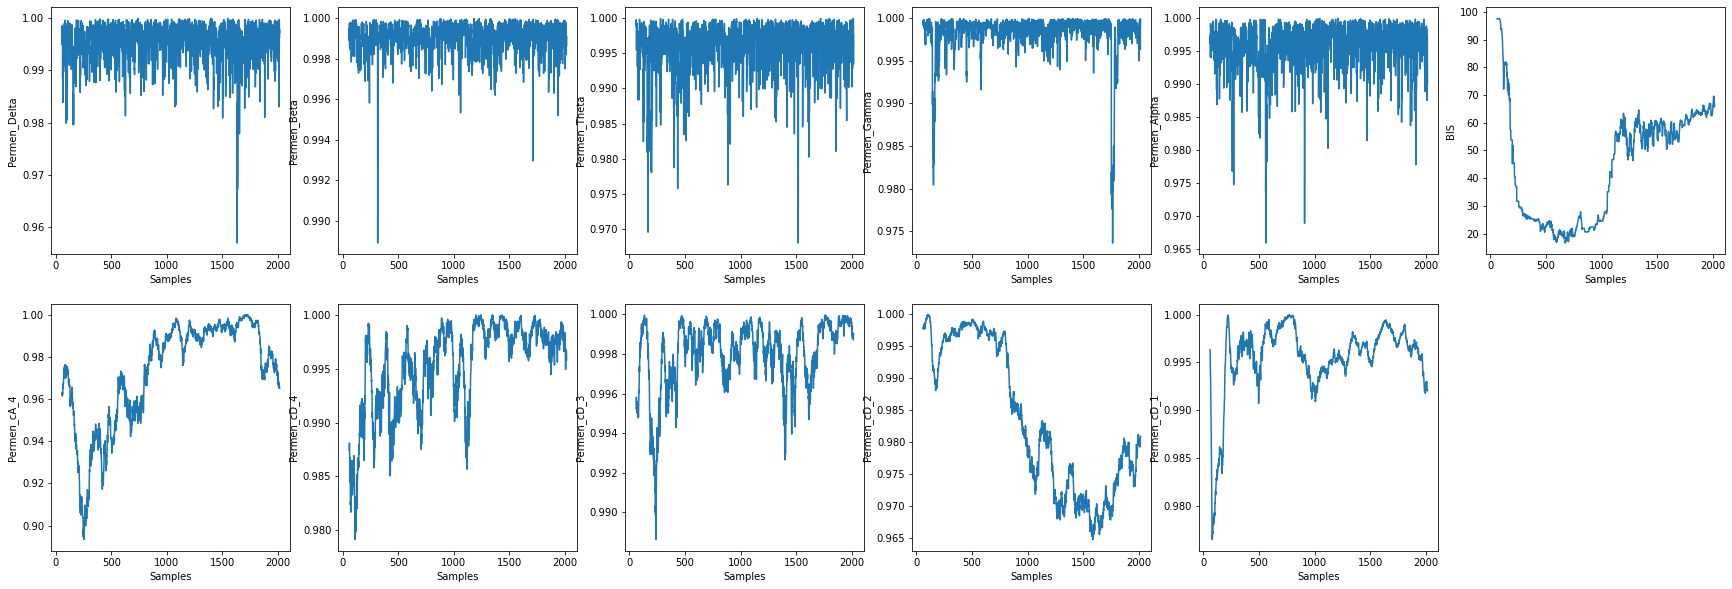

BIS against each parameter
--------------------------


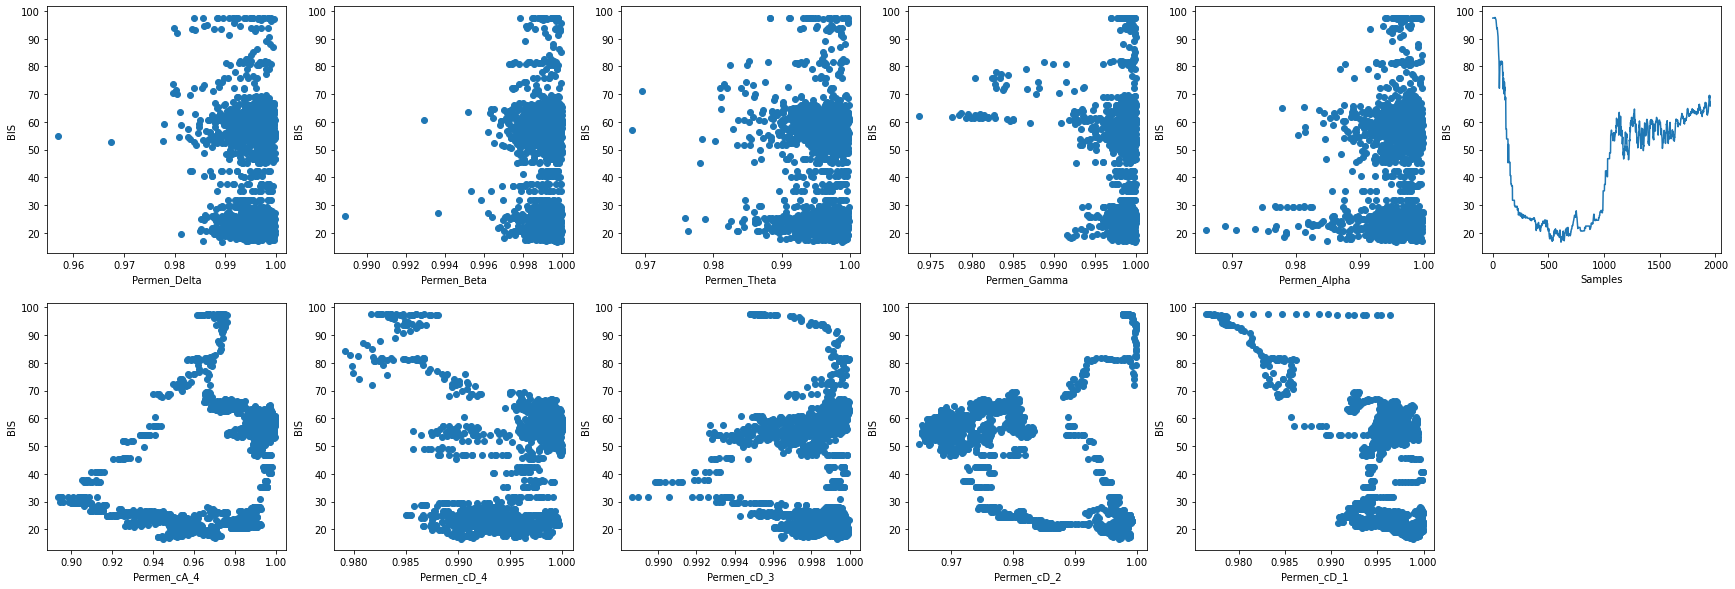



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 13_EEG20100609.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 13_EEG20100609.mat
-------------------------------------------------------


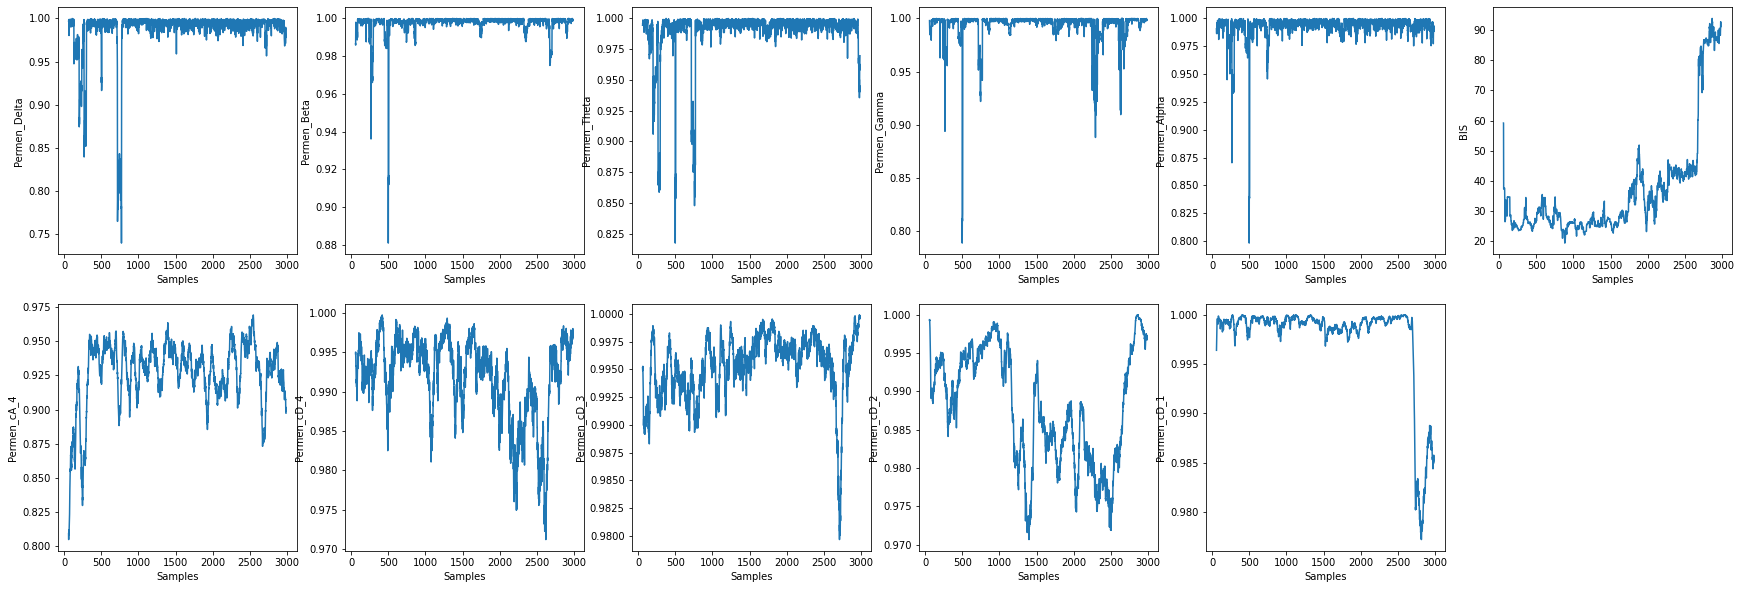

BIS against each parameter
--------------------------


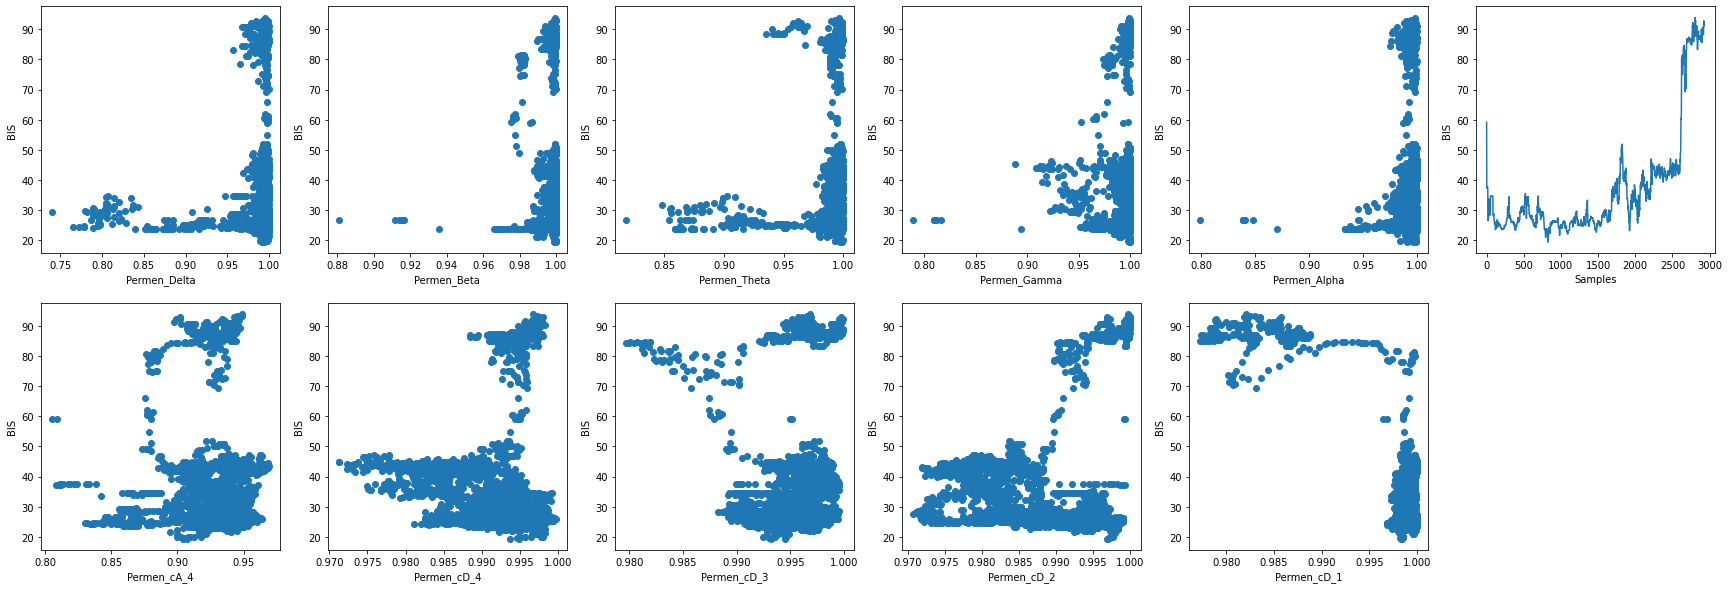



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 19_EEG201004072.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 19_EEG201004072.mat
-------------------------------------------------------


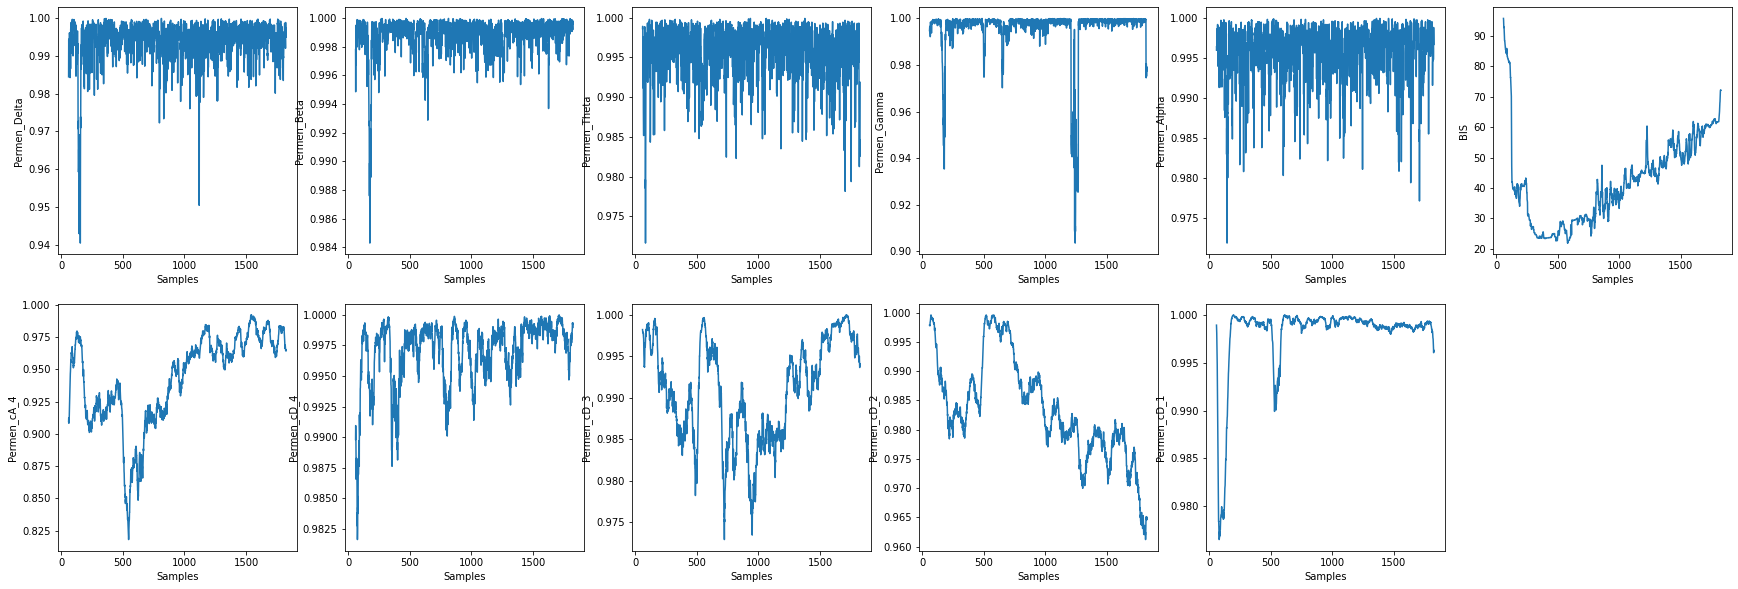

BIS against each parameter
--------------------------


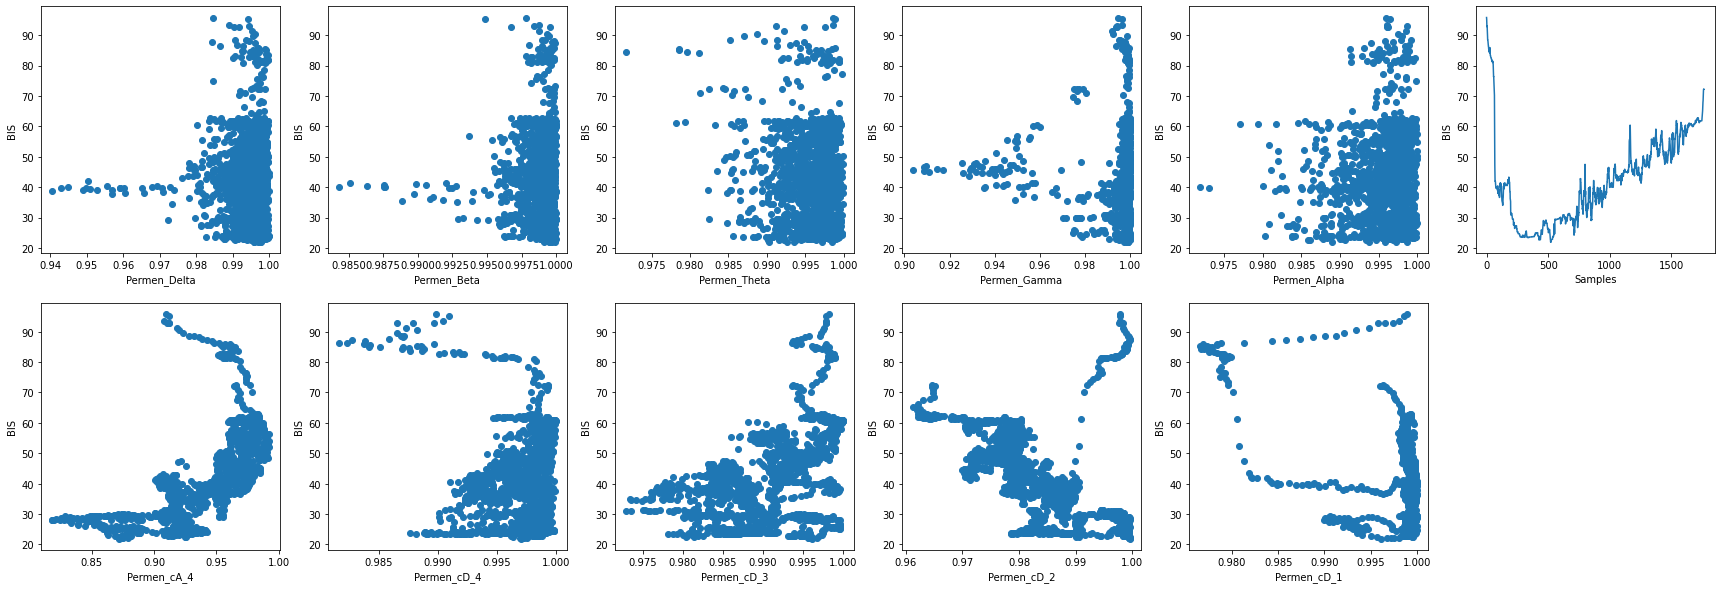



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 30_EEG200909091.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 30_EEG200909091.mat
-------------------------------------------------------


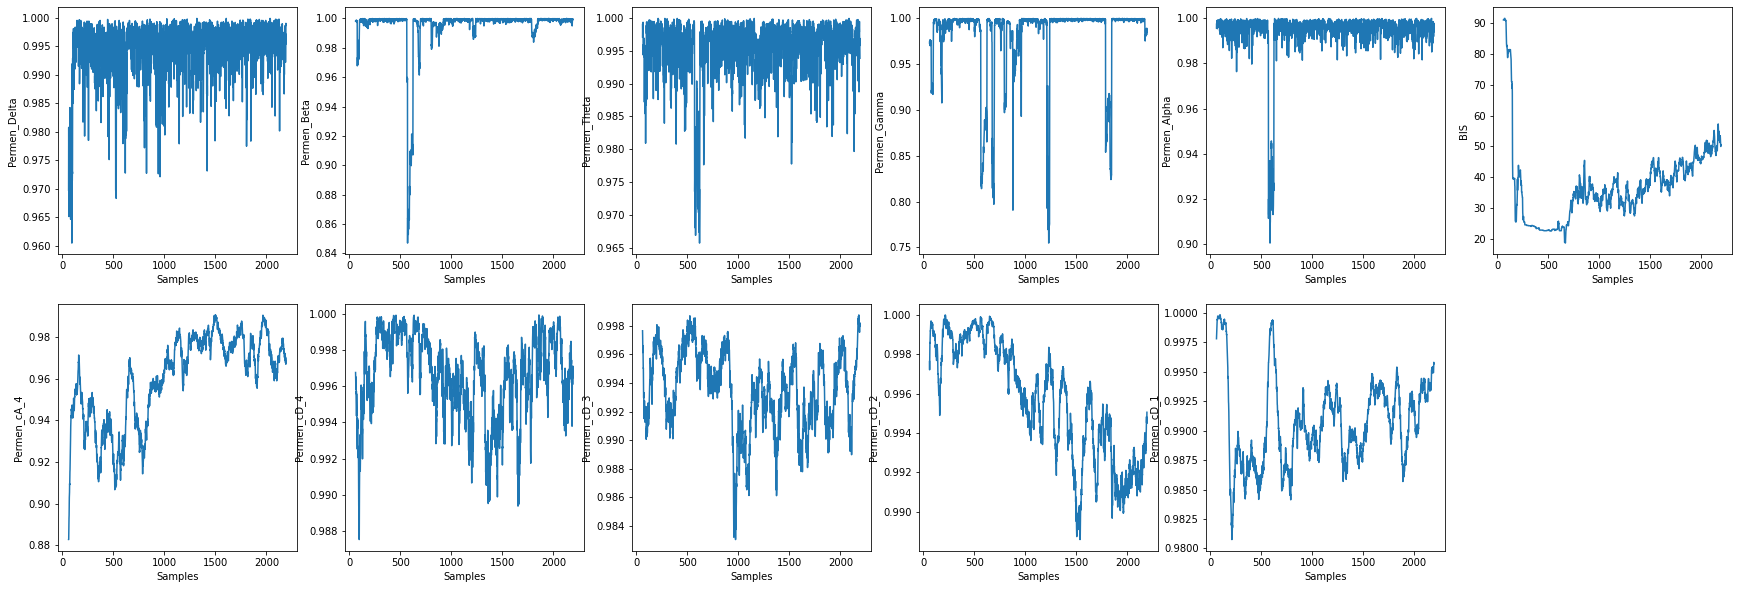

BIS against each parameter
--------------------------


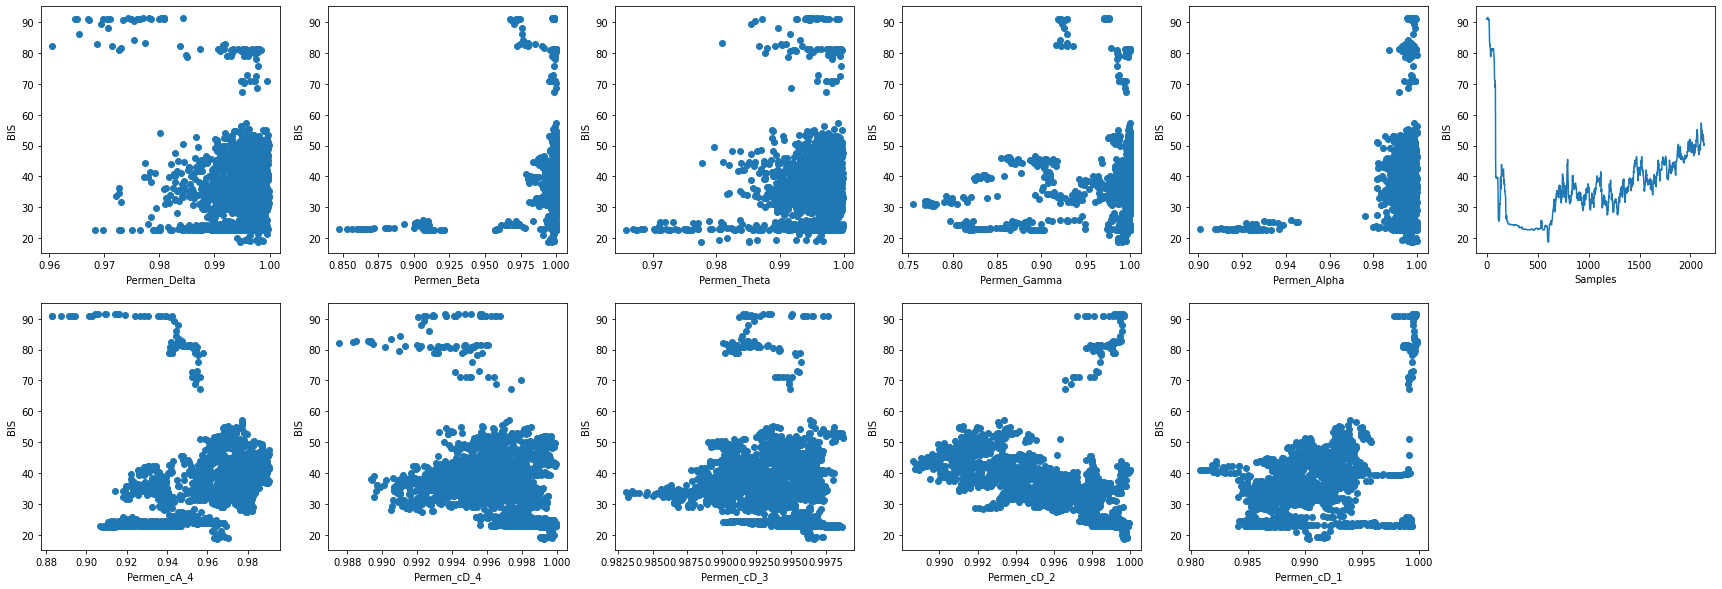



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 2_EEG200908190811.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 2_EEG200908190811.mat
-------------------------------------------------------


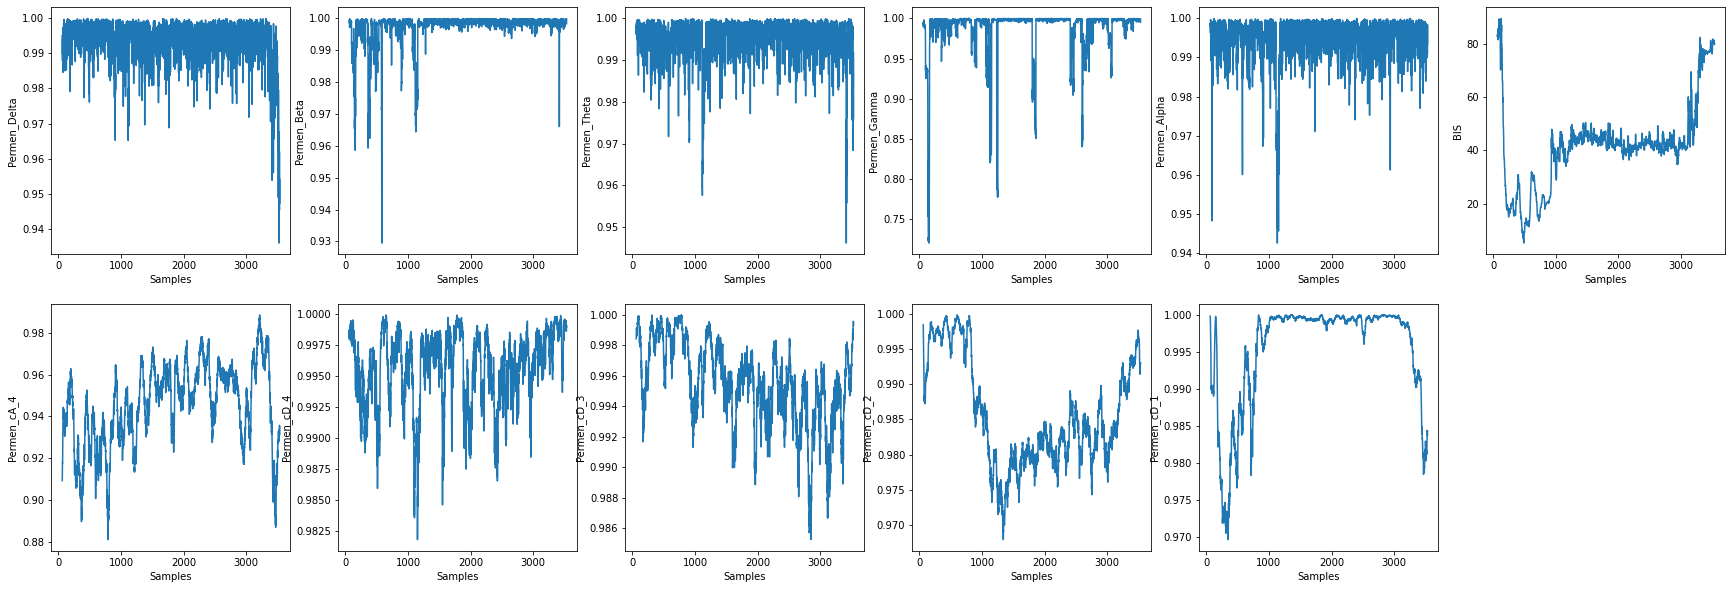

BIS against each parameter
--------------------------


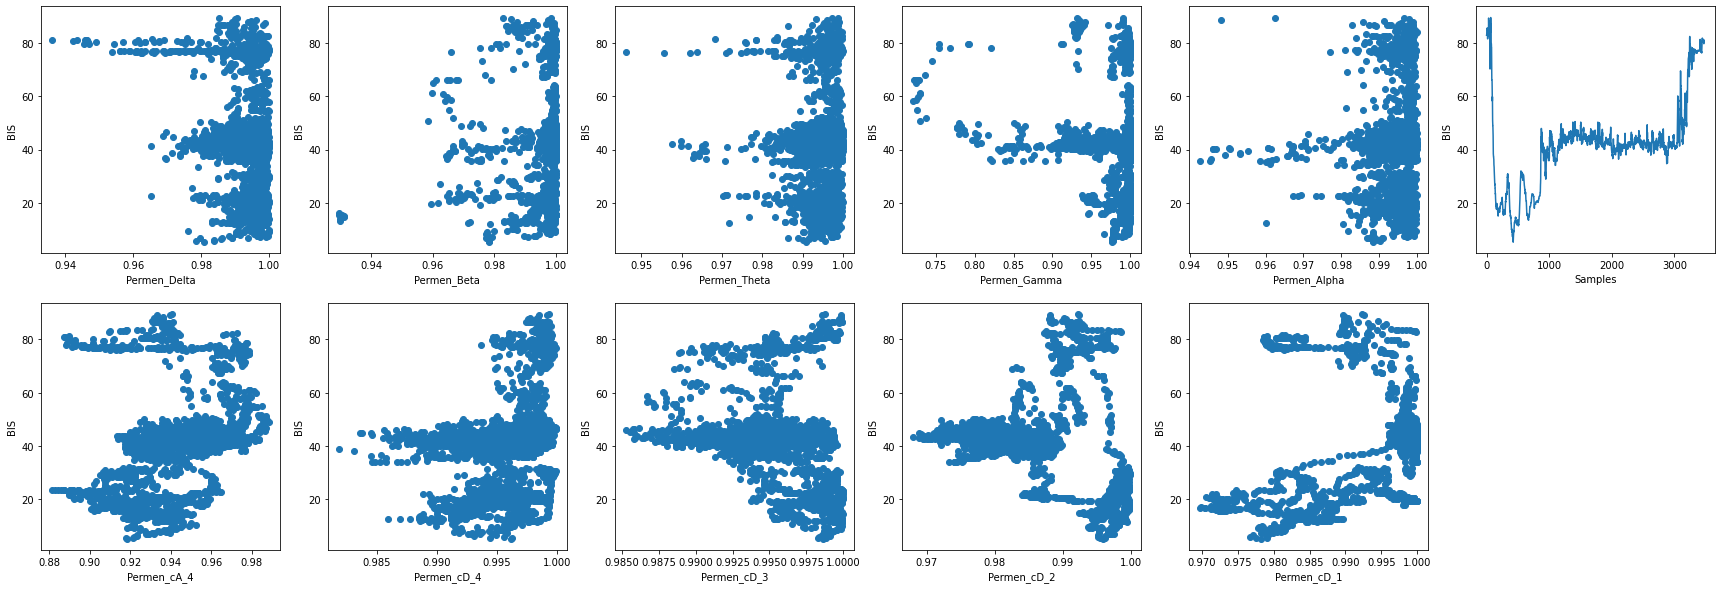



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 32_EEG201004071.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 32_EEG201004071.mat
-------------------------------------------------------


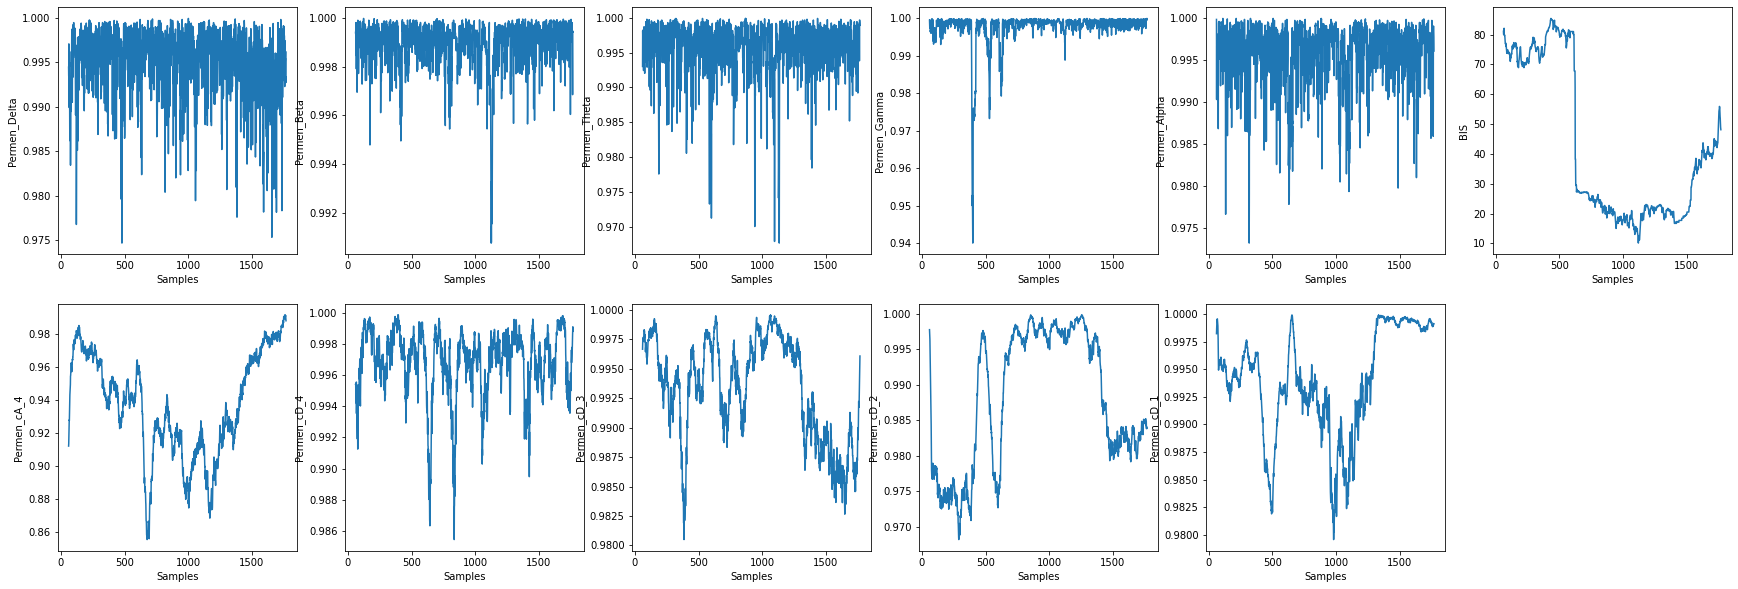

BIS against each parameter
--------------------------


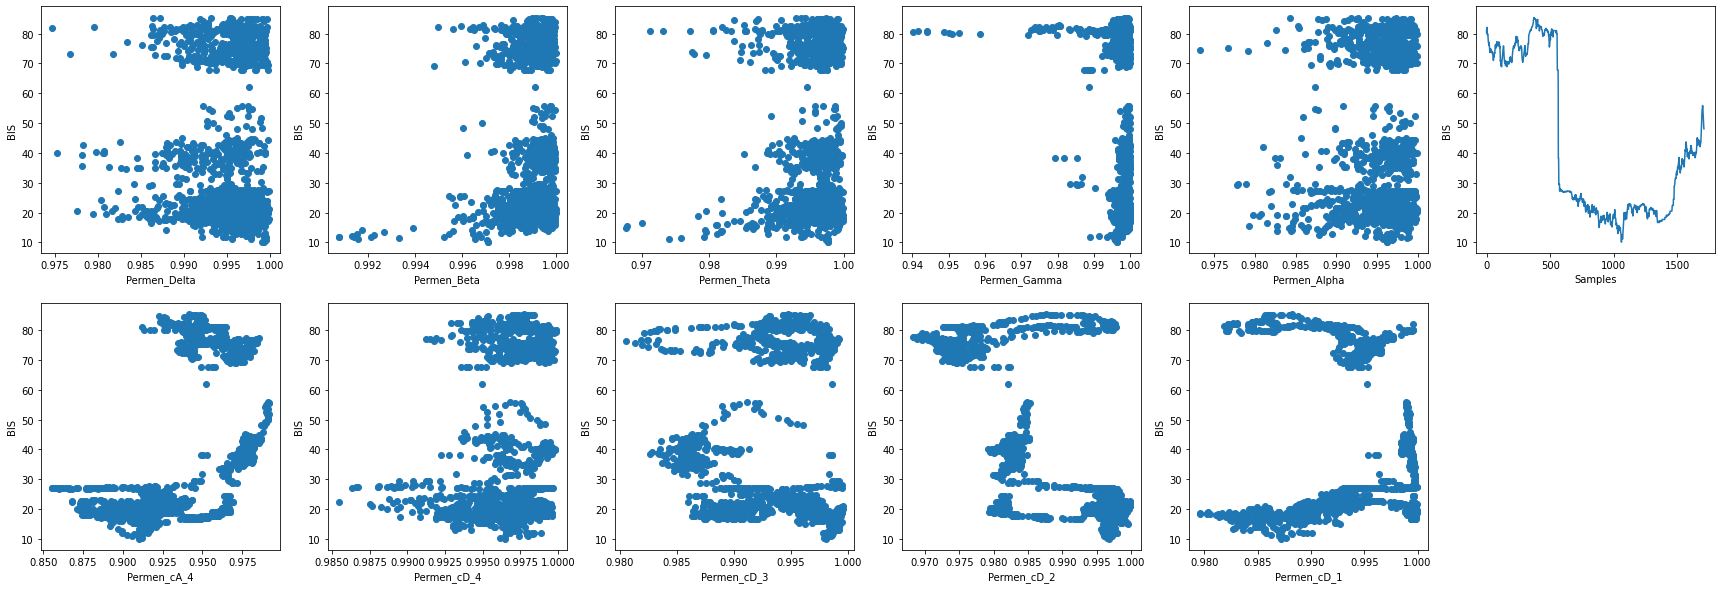



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 20_EEG201005241.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 20_EEG201005241.mat
-------------------------------------------------------


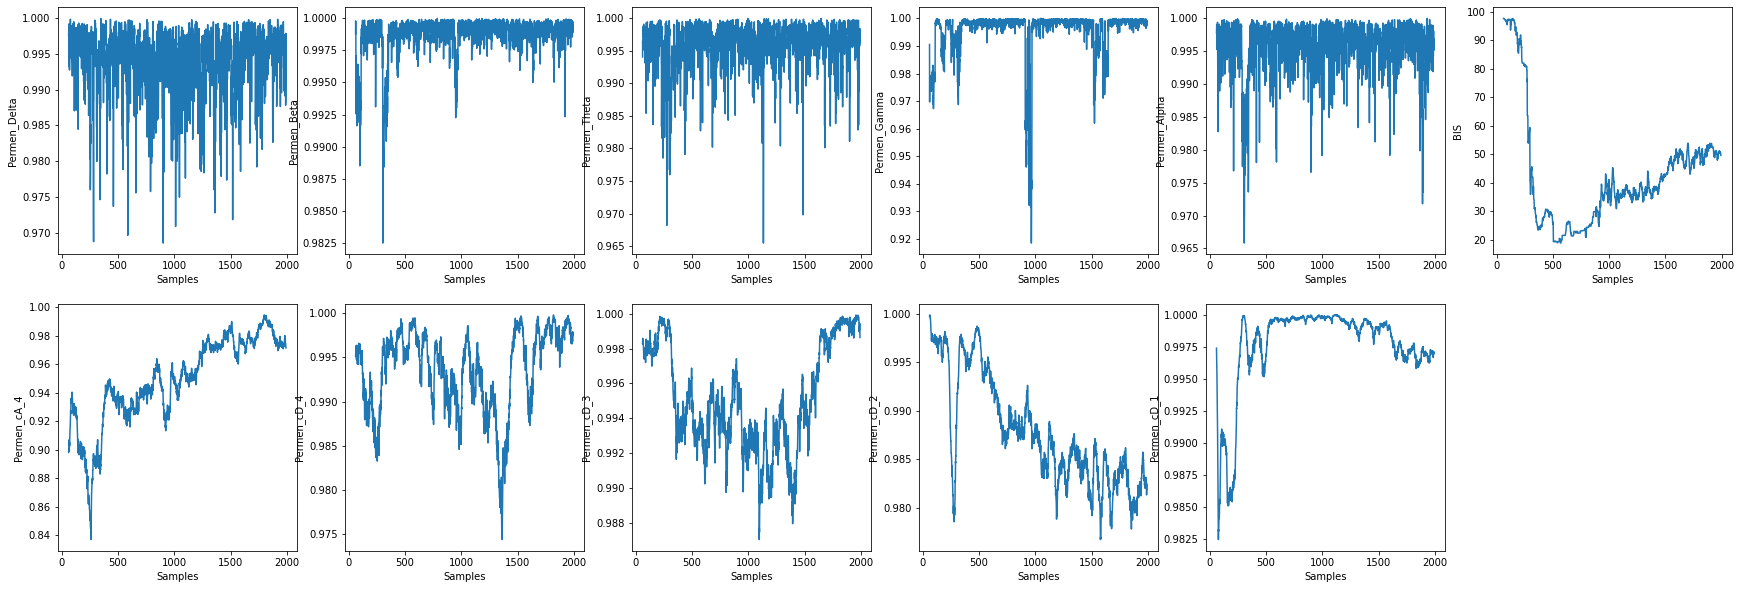

BIS against each parameter
--------------------------


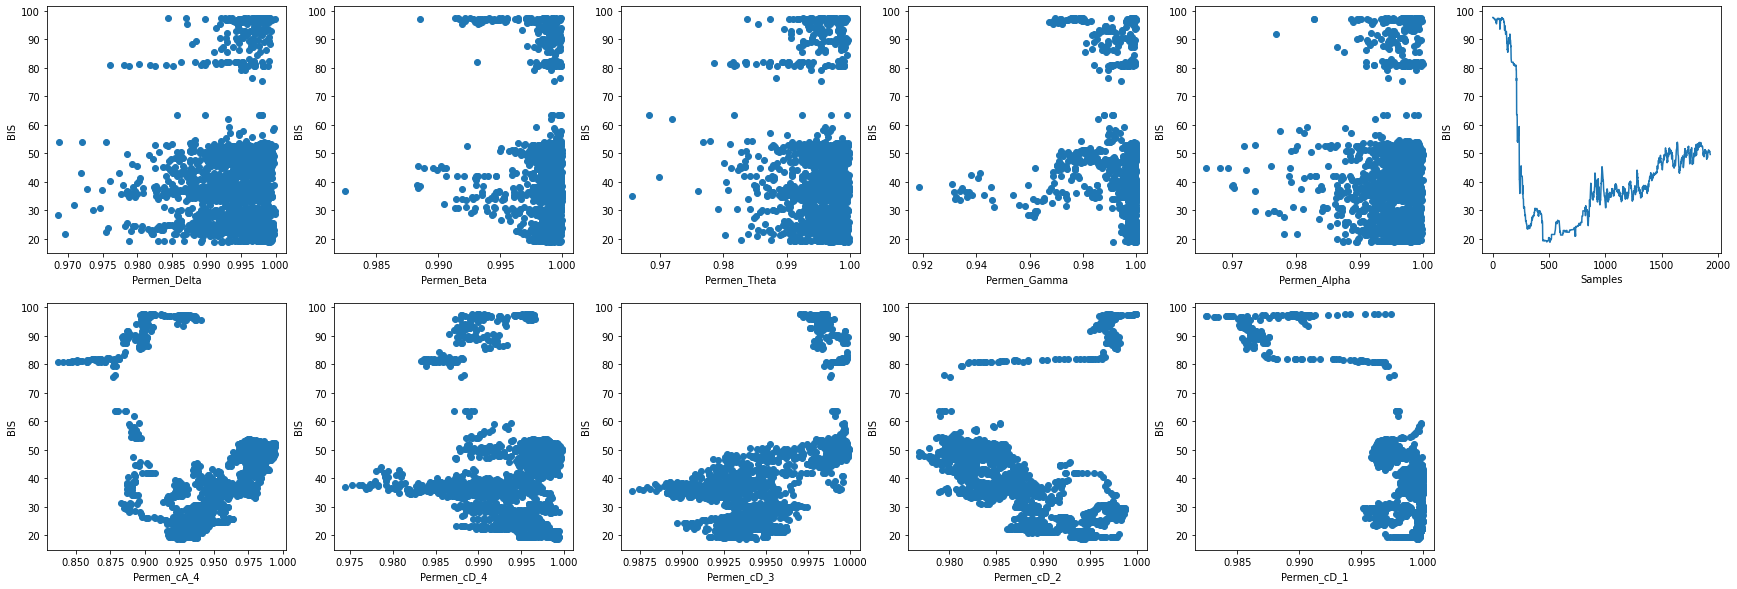



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 7_EEG201005241657.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 7_EEG201005241657.mat
-------------------------------------------------------


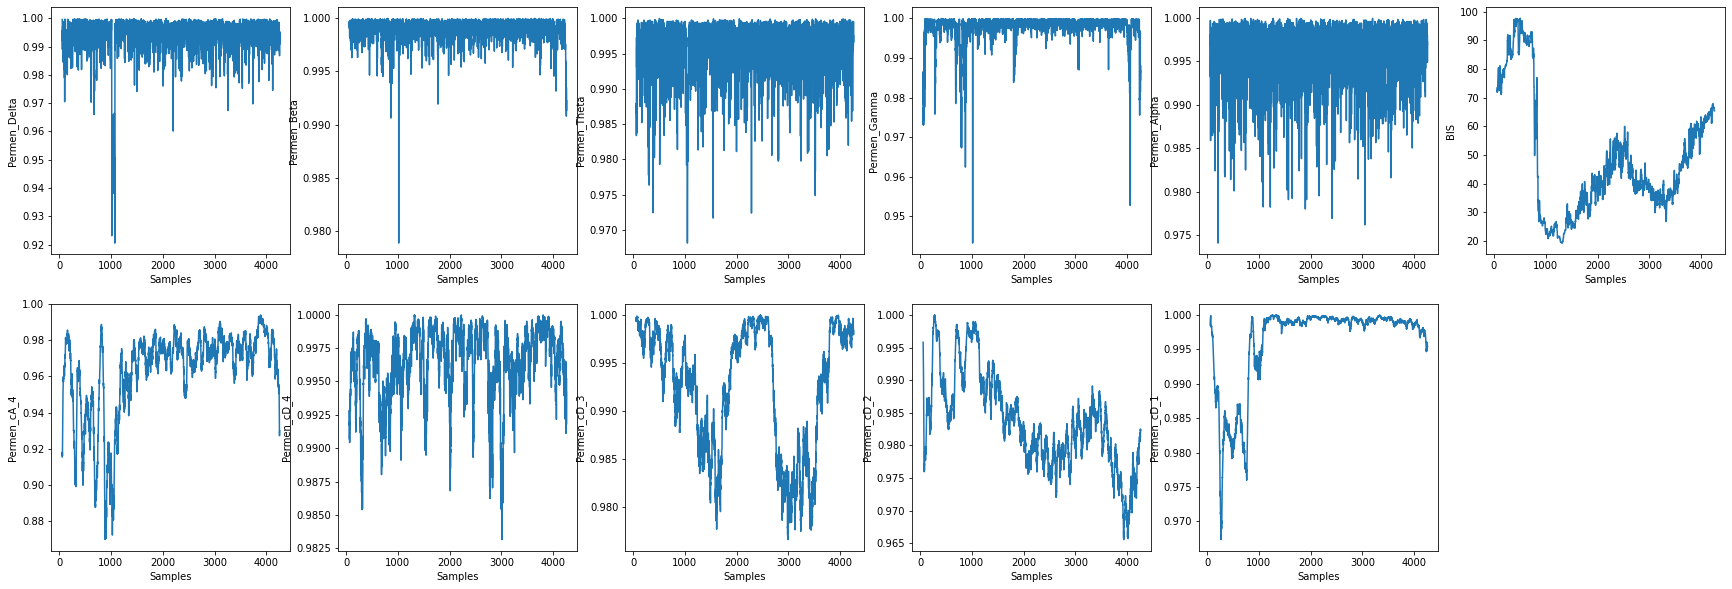

BIS against each parameter
--------------------------


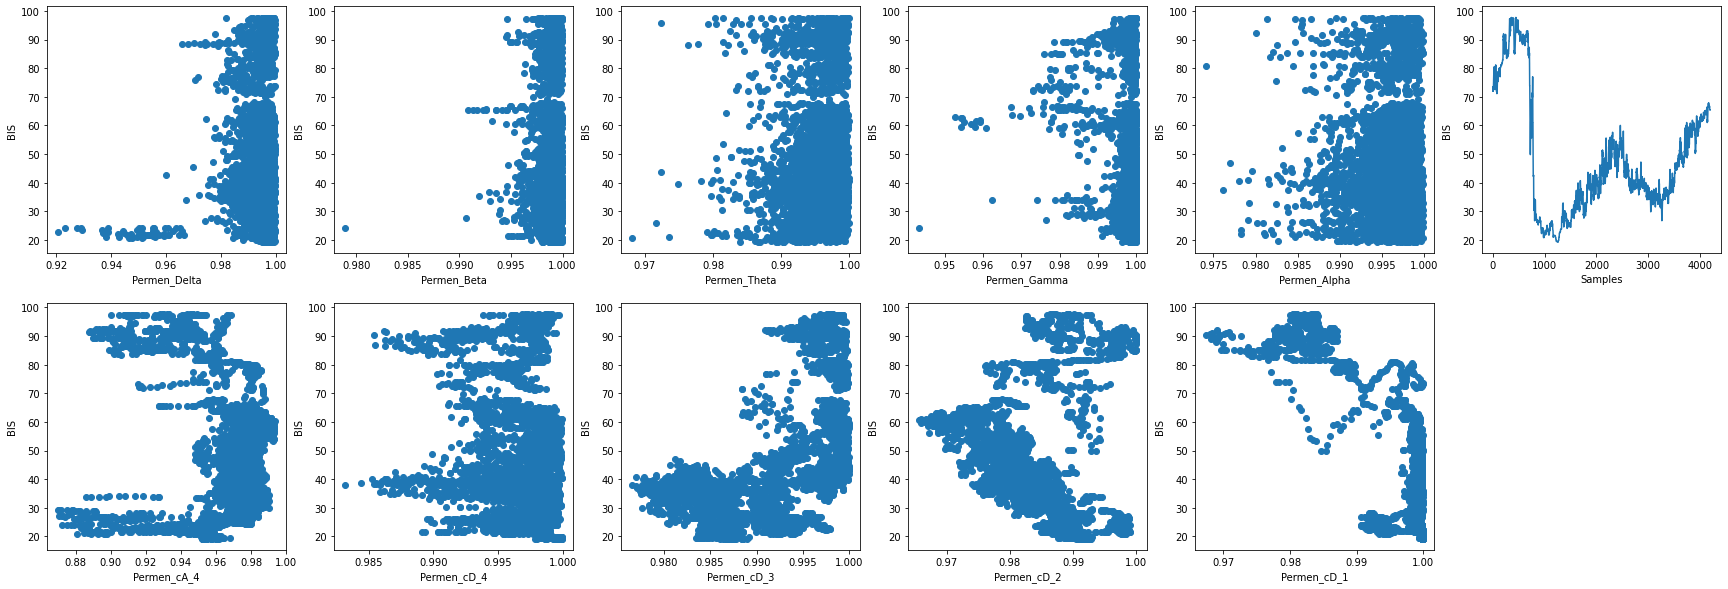



Concatenating the data to create 10-feature dataset...
Done Concatenating
File: 3_EEG200908190921.mat

A plot of the Parameters
--------------------------
Saving dataset for future use

Making relevant graphs for Patient 3_EEG200908190921.mat
-------------------------------------------------------


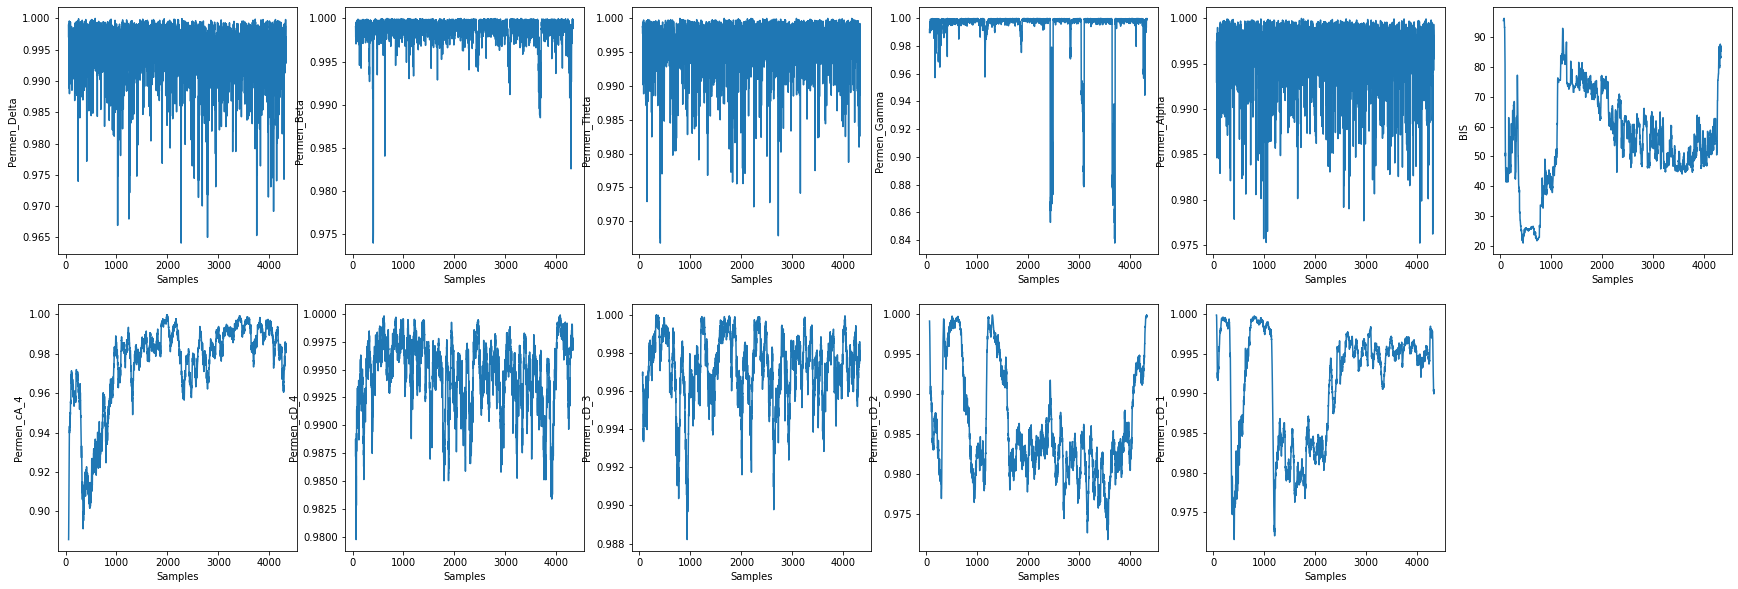

BIS against each parameter
--------------------------


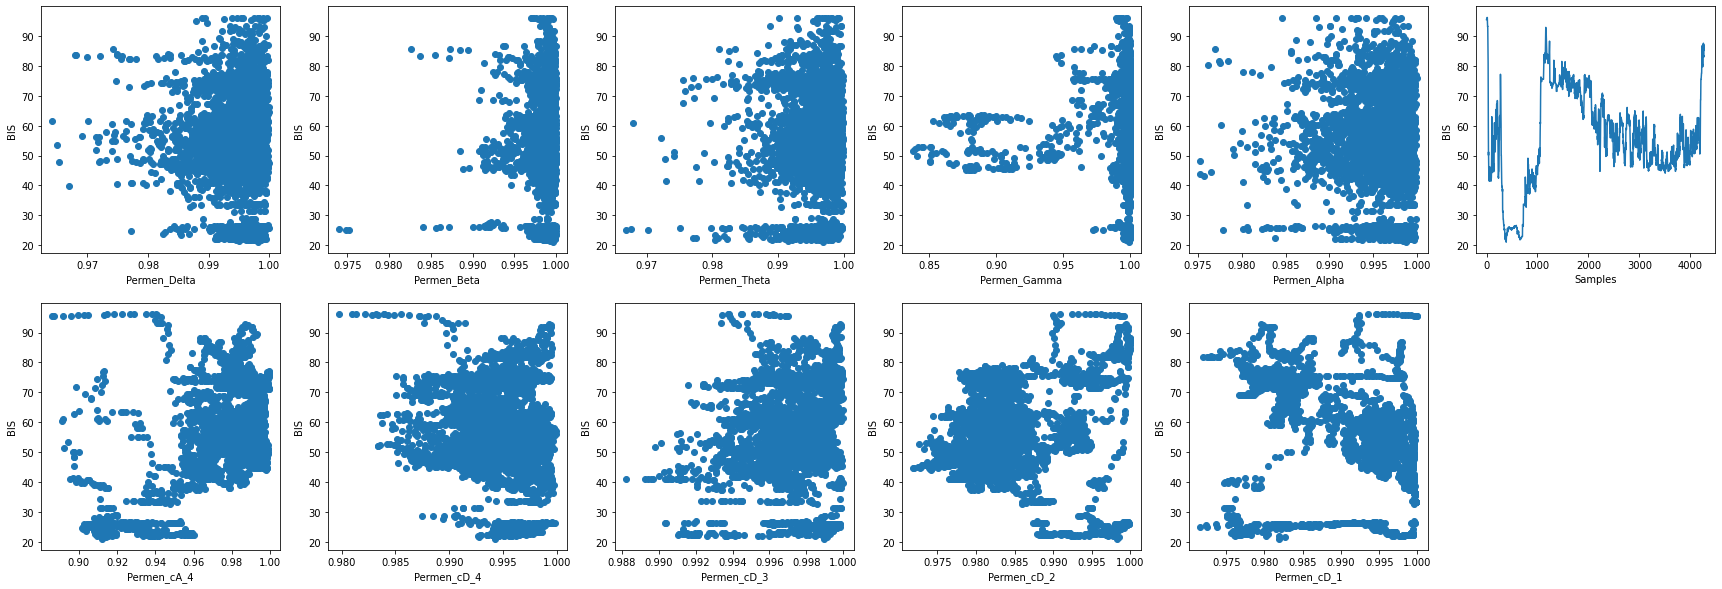



Concatenating the data to create 10-feature dataset...
Done Concatenating
Consolidating the files to create data.csv
Done Saving!


In [18]:
folders = ["SampEntropy", "Higuchi", "Katz", "PermEntropy"]
methods = ["samp_ent", "hig", "katz", "perm_ent"]

for folder, method in zip(folders, methods):
    print("Folder: {}, Method: {}".format(folder, method))
    
    # Run the visualise function to do all the work :)
    visualise(training_set, method=method, folder=folder)

<br/>

<br/>

# Regression with consolidated data

The **DFT** and **DWT** data of each patient are concatenated to create a 10-feature dataset. The data is then consolidated across all patients to create a larger dataset.

In [5]:
# Import patient 1 data
patients_df = pd.read_csv("./Class A train sets/SampEntropy/Modified/data.csv")

patients_df.head()

Sampen_Delta  Sampen_Beta  Sampen_Theta  Sampen_Gamma  Sampen_Alpha  \
0      0.692493     2.021880      1.902279      2.022642      2.421849   
1      0.681645     2.100901      1.863993      2.010728      2.252794   
2      0.642997     2.108815      1.947717      2.096499      2.568288   
3      0.597286     2.041619      1.987504      2.090416      2.328064   
4      0.631320     2.097276      1.918759      2.055421      2.082562   

   SampenCA_4  SampenCD_4  SampenCD_3  SampenCD_2  SampenCD_1   BIS  
0    0.376660    0.388828    0.404056    0.295259    0.178418  95.8  
1    0.404385    0.407630    0.439146    0.317506    0.190632  95.8  
2    0.442947    0.448432    0.476659    0.342623    0.202869  95.8  
3    0.492027    0.474499    0.492246    0.371085    0.212331  95.6  
4    0.552274    0.541834    0.530041    0.403649    0.223405  95.6

In [25]:
patients_df.shape

(30141, 12)

<br/>

## Performing regression: All methods
<hr>

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
metrics = {}

In [16]:
def plot_regression(data, normalize=False):
    
    """
    Perform regression between parameters and the BIS
    
    
    Parameters
    ----------
    data: pd.DataFrame
        The dataset. Must contain a column called 'BIS'.
        

    """
    
    global metrics
    
    for column in data.columns:
        
        if column == 'BIS':
            continue
    
        X = data[column]
        X = X[:, np.newaxis]
        y = data['BIS']

        # Perform regression
        reg = LinearRegression(n_jobs=-1, normalize=normalize).fit(X, y)

        # Predictions
        y_predicted = reg.predict(X)

        # Show the score and r2
        mse = mean_squared_error(y, y_predicted)
        r2 = r2_score(y, y_predicted)

        # keep track of metrics

        metrics["{}_mse".format(column)] = mse
        metrics["{}_r2".format(column)] = r2


        # Plot the graph
        plt.figure(figsize=(10,8))
        plt.scatter(data[column], data['BIS'], label="Data", c="steelblue")
        plt.plot(X, y_predicted, label="Regression", c="red")
        plt.xlabel(column)
        plt.ylabel('BIS')
        plt.legend(loc="upper left")
        plt.show()


Performing regression with SampEntropy measures...


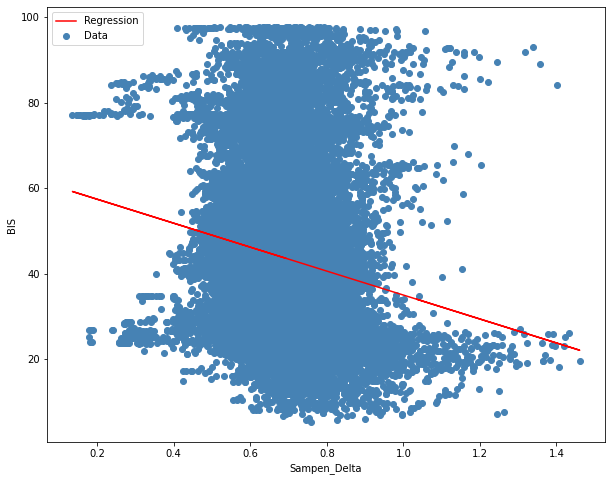

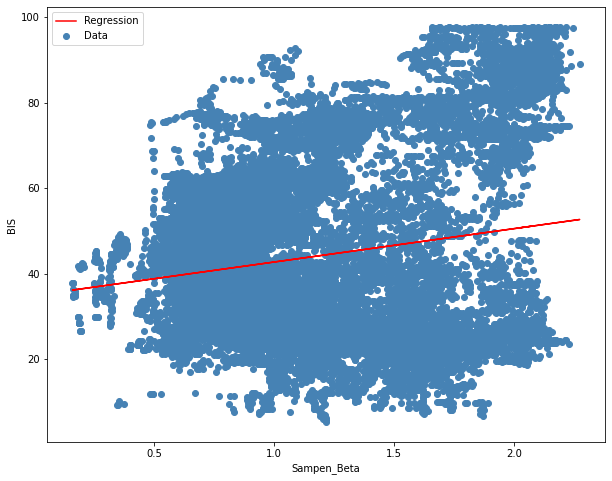

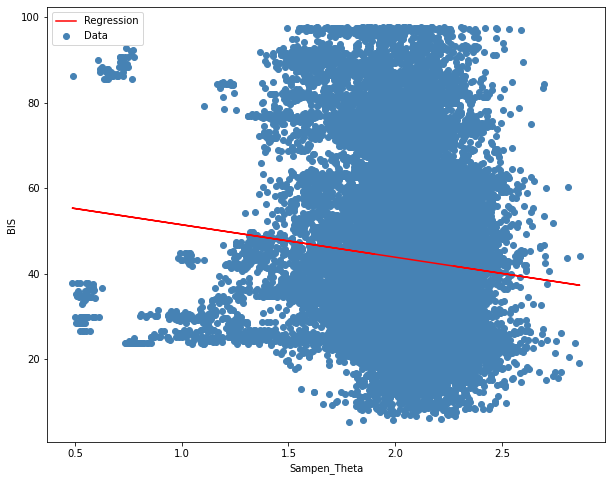

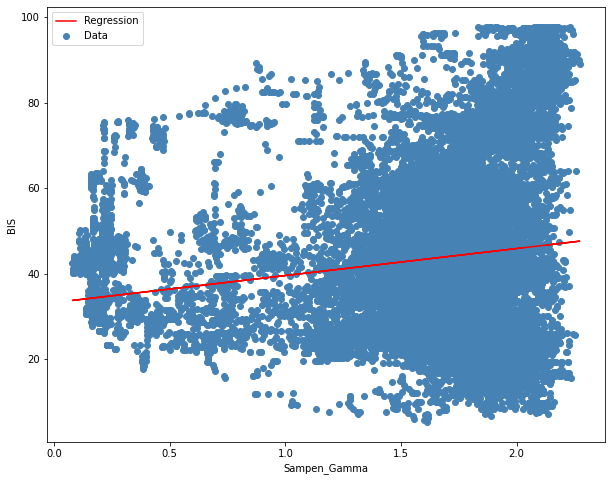

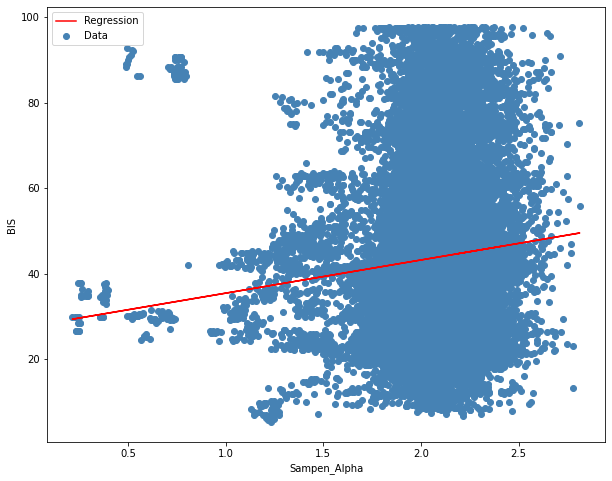

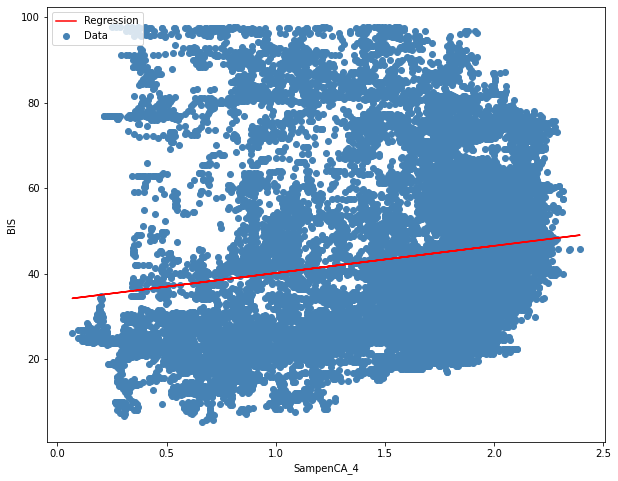

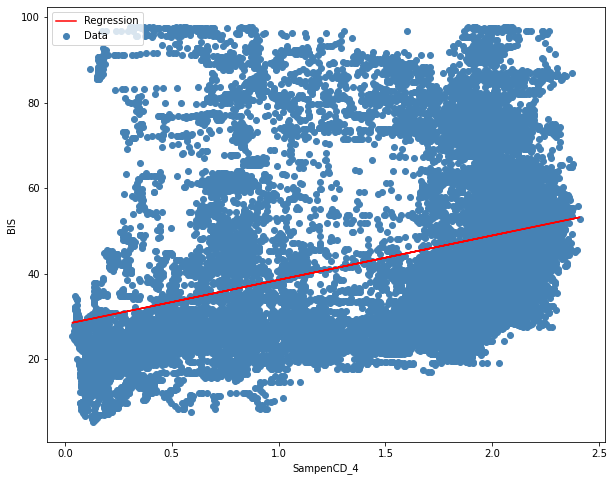

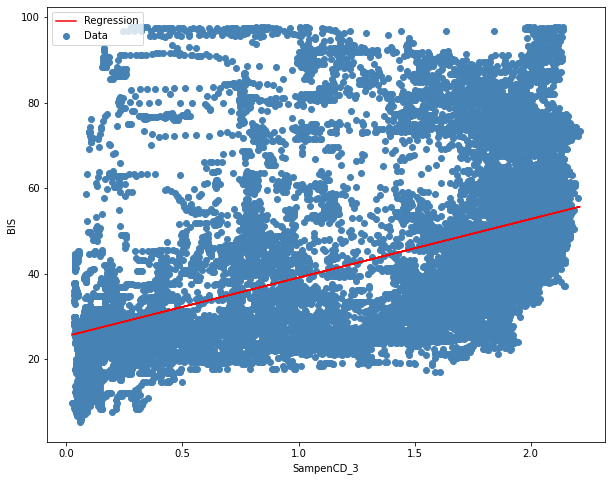

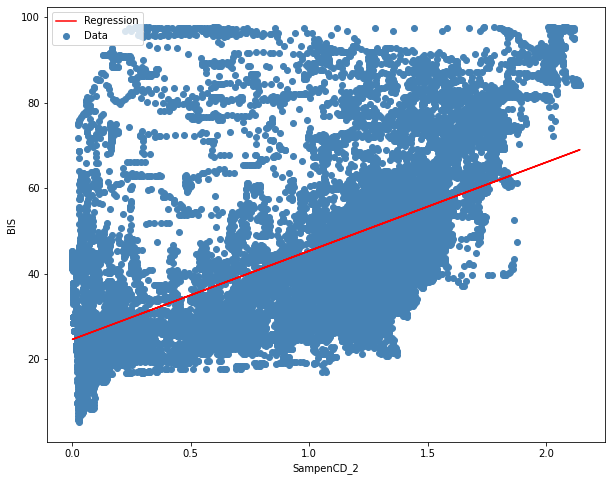

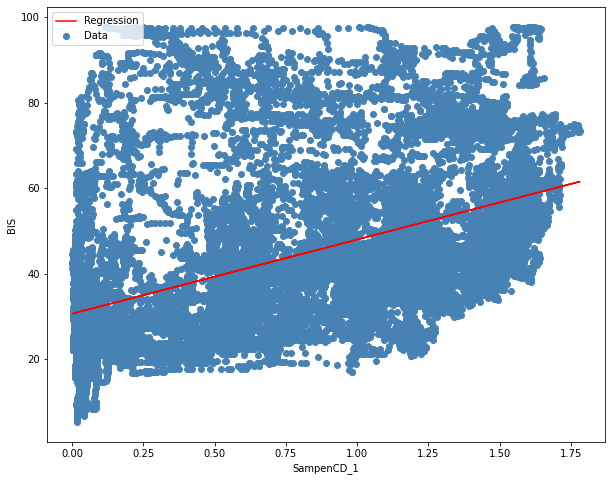

Done!


Performing regression with Higuchi measures...


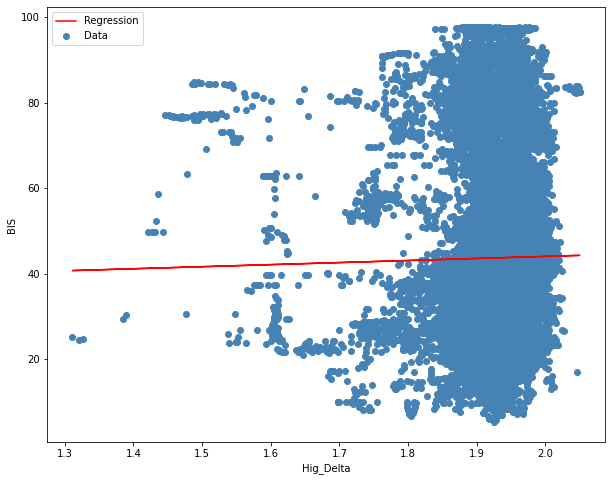

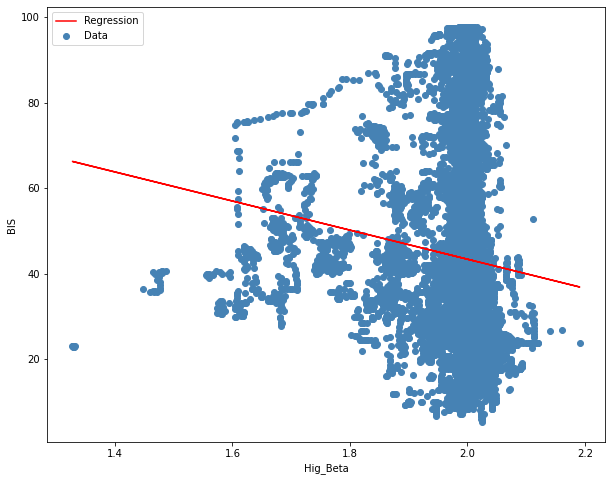

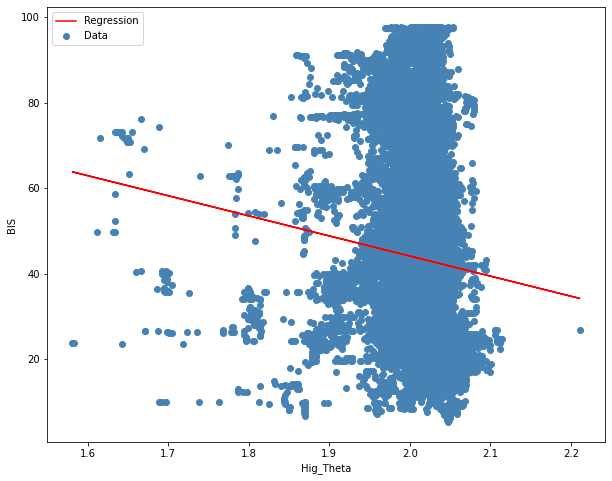

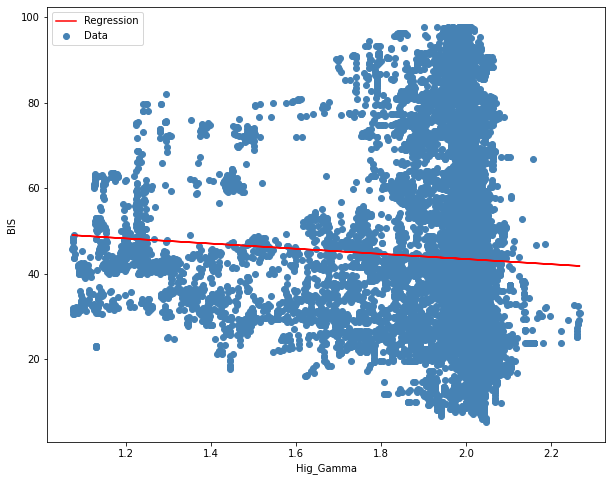

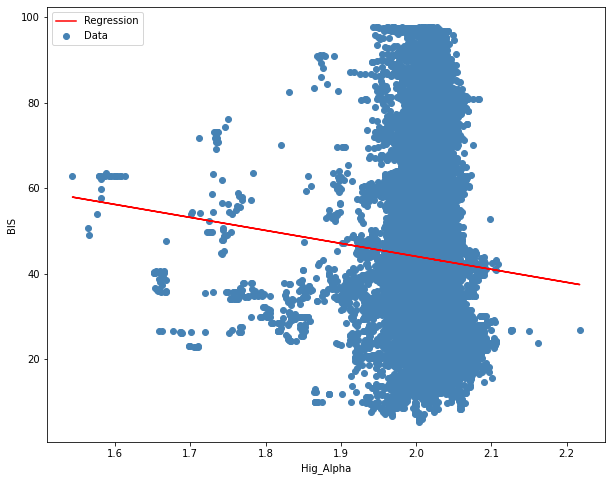

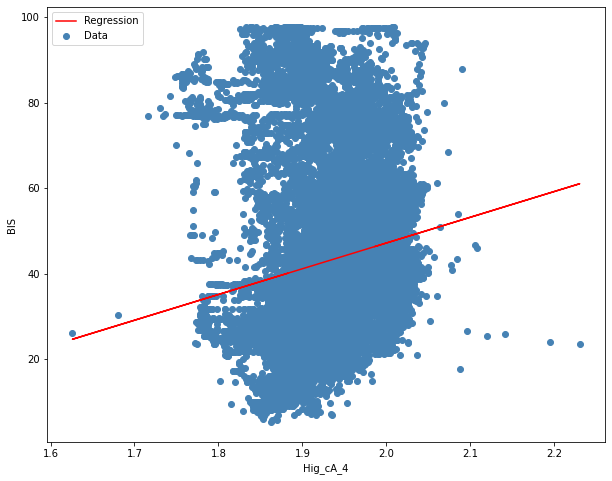

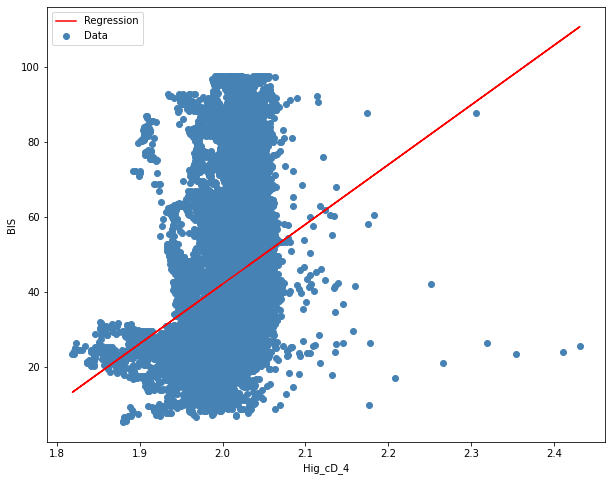

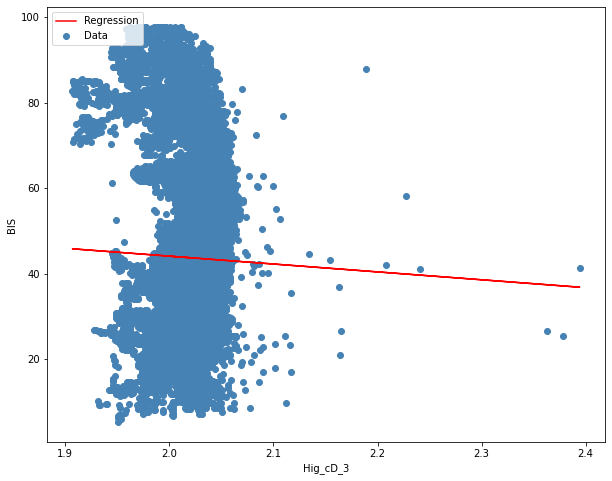

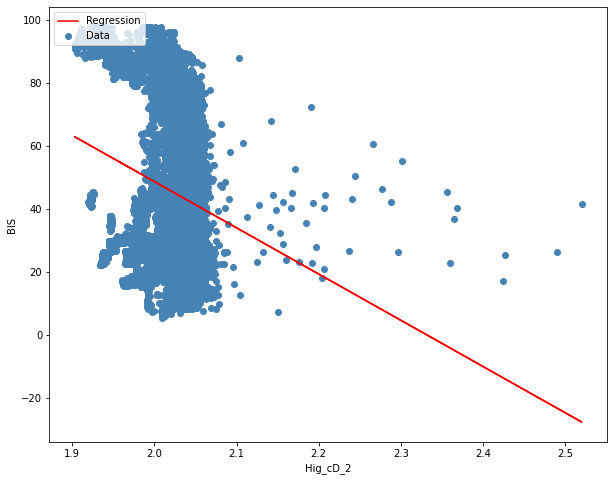

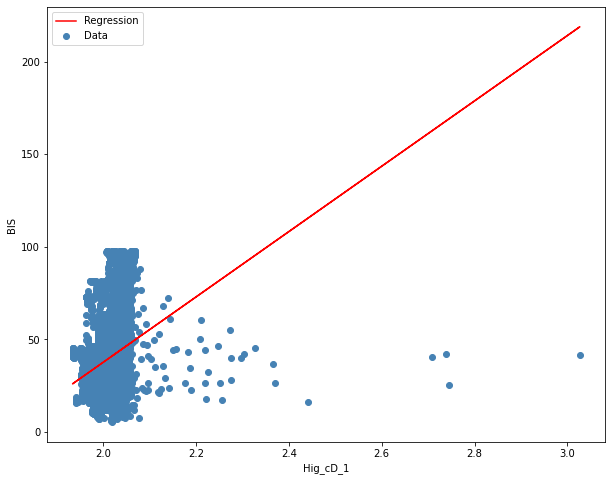

Done!


Performing regression with Katz measures...


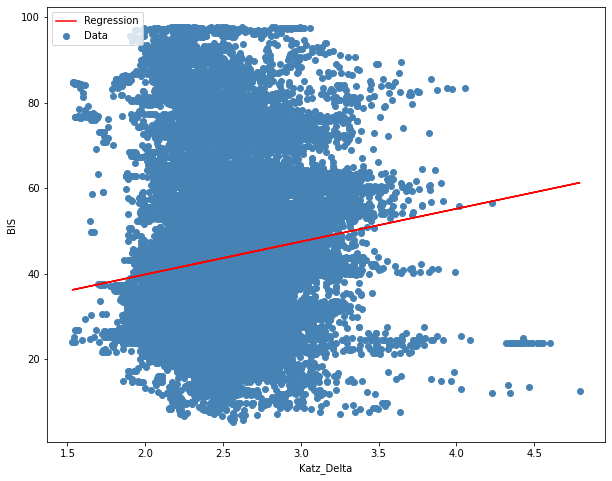

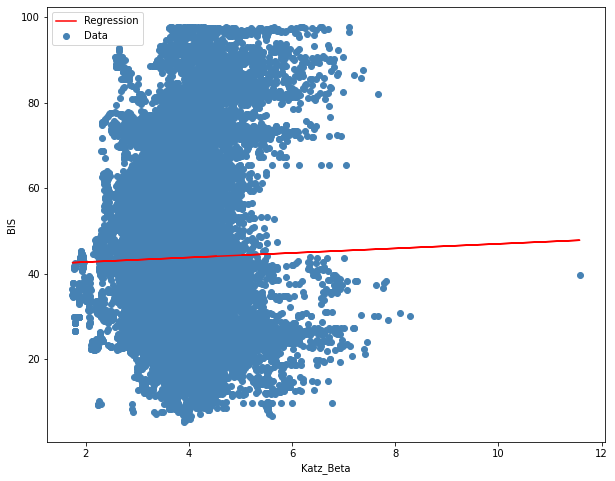

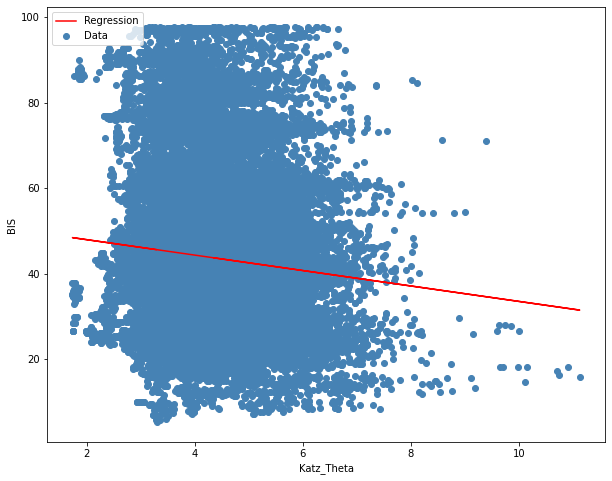

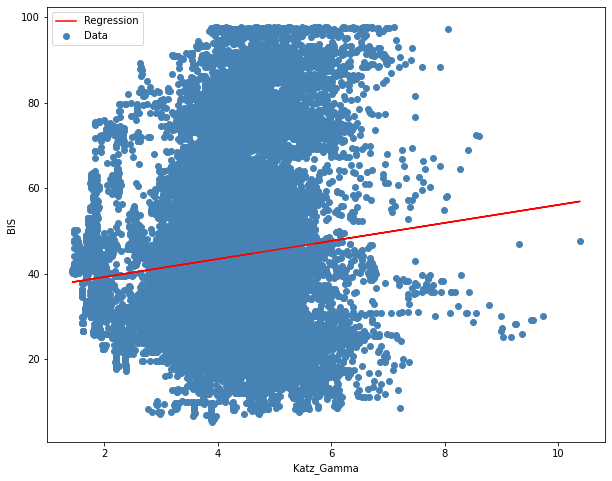

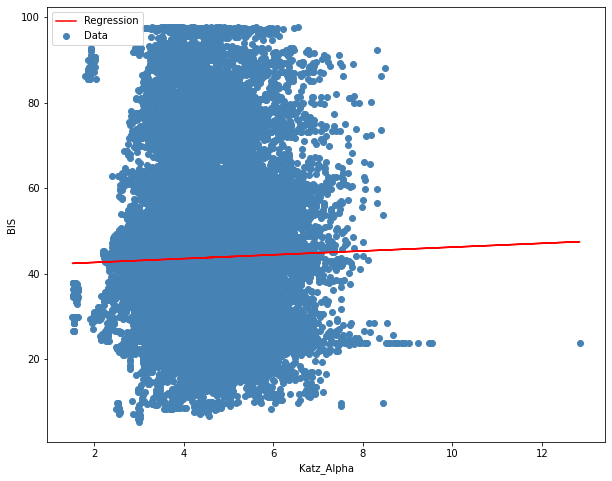

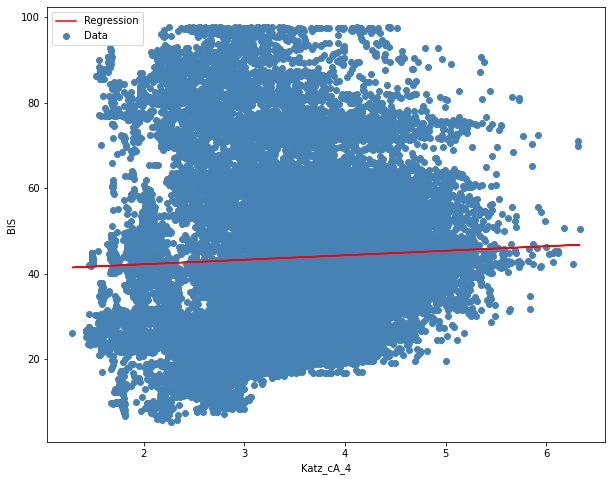

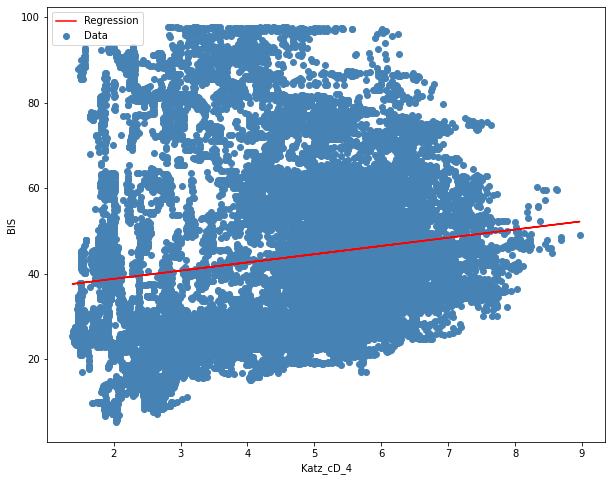

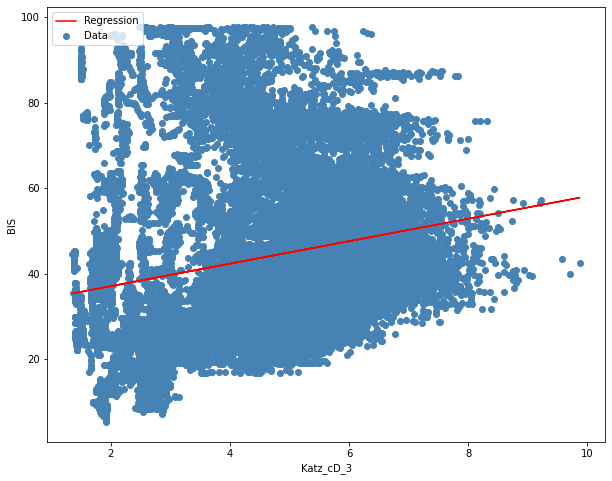

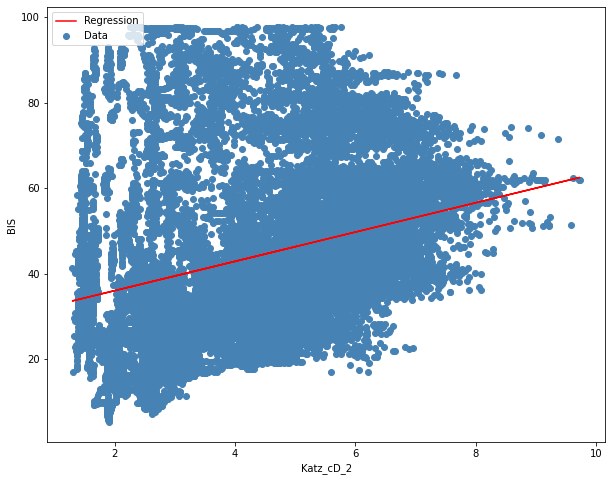

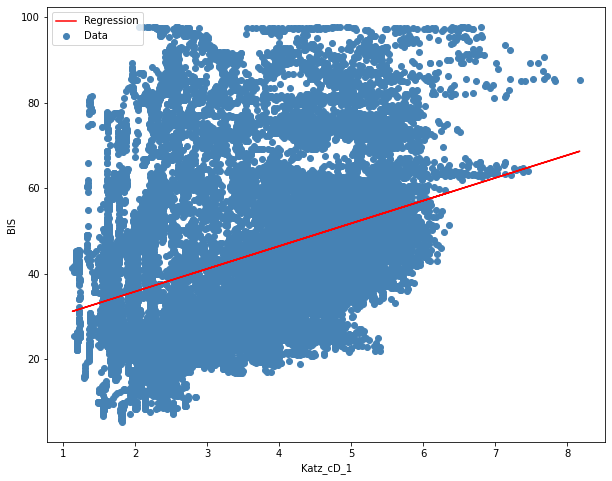

Done!


Performing regression with PermEntropy measures...


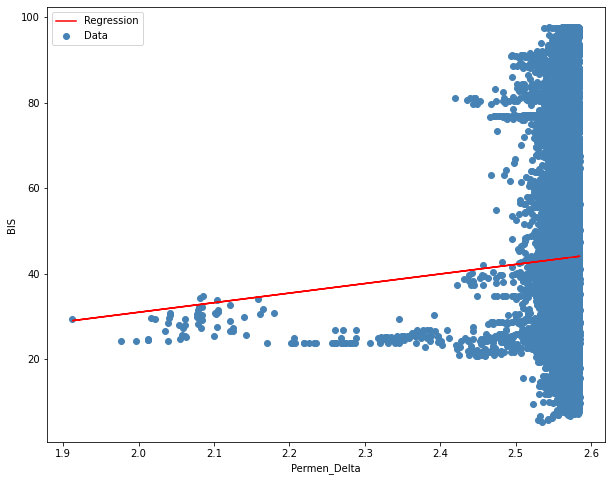

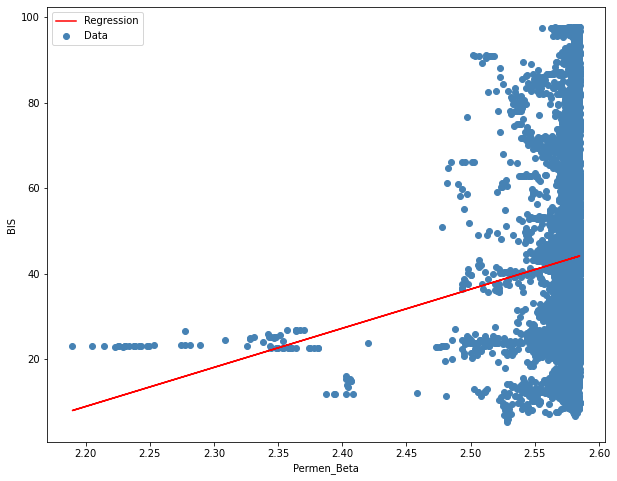

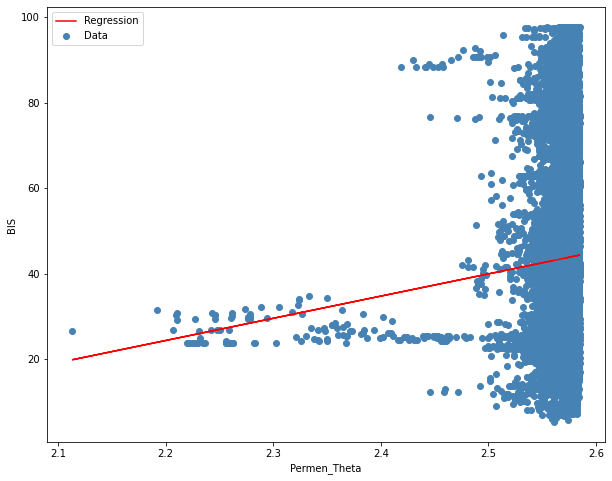

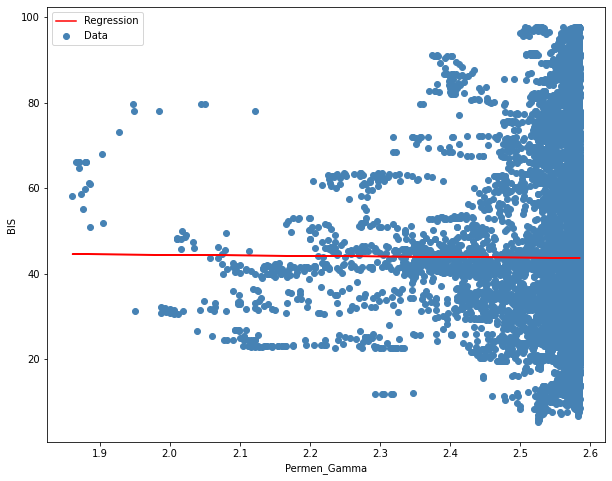

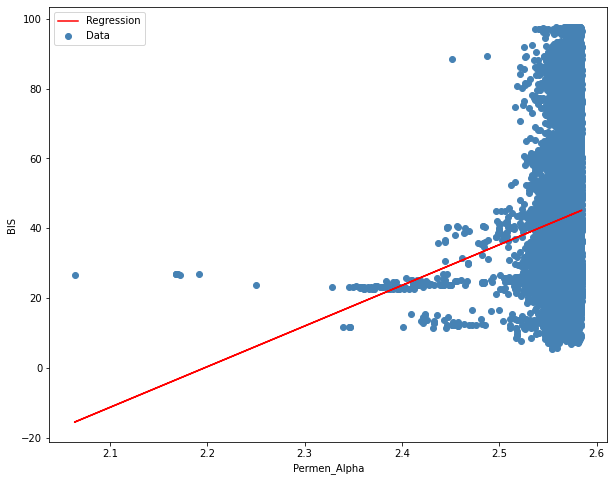

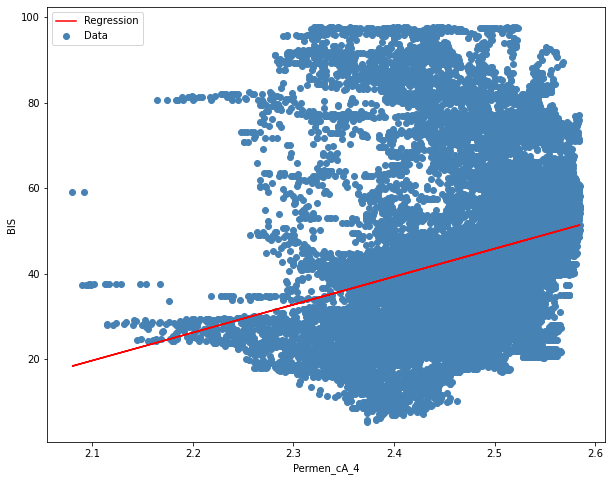

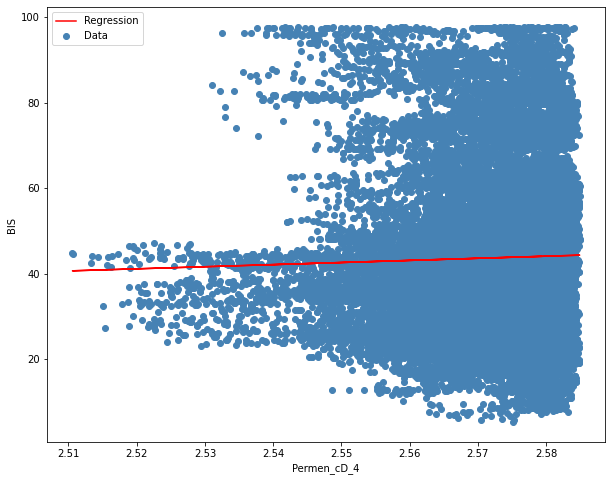

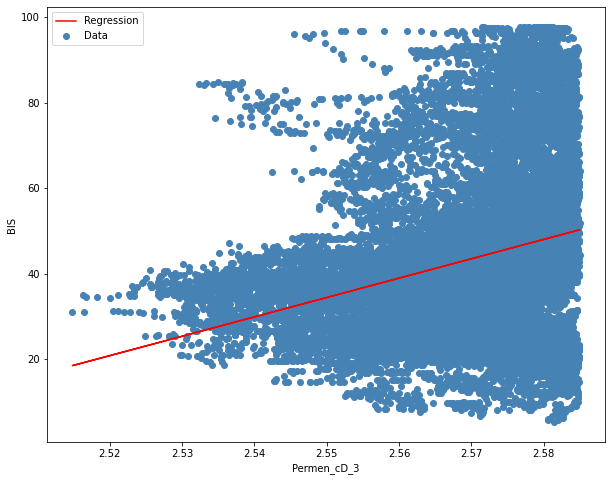

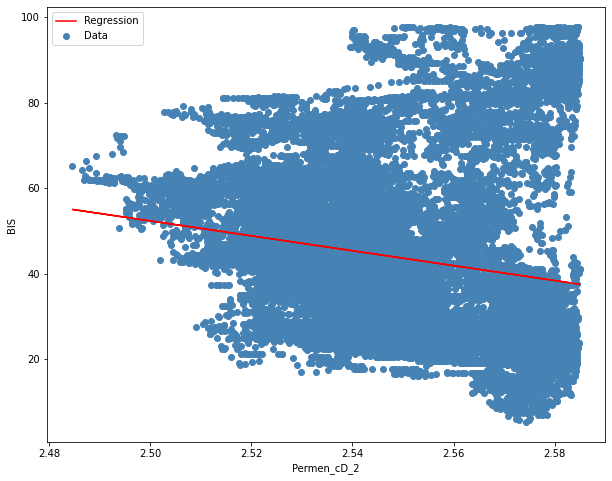

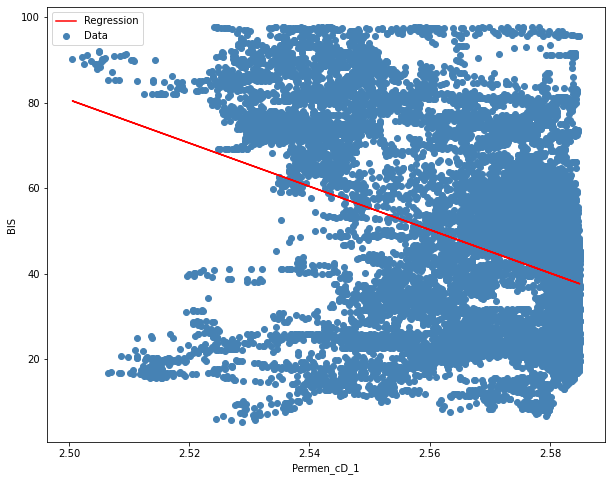

Done!




In [17]:
folders = ["SampEntropy", "Higuchi", "Katz", "PermEntropy"]

for folder in folders:
    data = pd.read_csv("./Class A train sets/{}/Modified/data.csv".format(folder))
    
    print("Performing regression with {} measures...".format(folder))
    plot_regression(data)
    print("Done!")
    print()
    print()

In [19]:
# Metrics
metrics_df = pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

metrics_df.head()

Metrics      Values
0  Sampen_Delta_mse  353.317664
1   Sampen_Delta_r2    0.029748
2   Sampen_Beta_mse  352.422095
3    Sampen_Beta_r2    0.032208
4  Sampen_Theta_mse  360.648028

<br/>

## Visualise MSE and r2

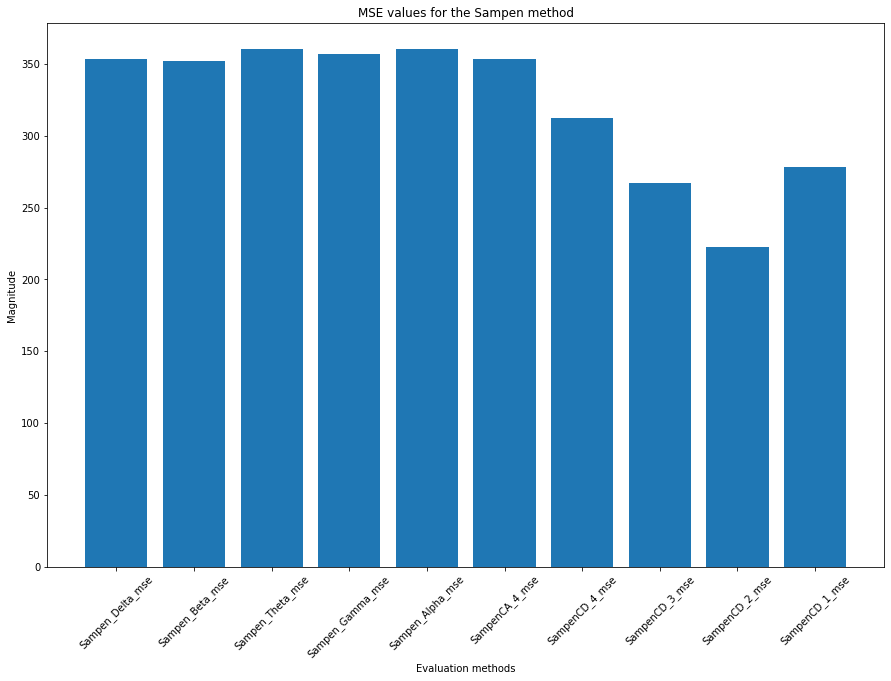

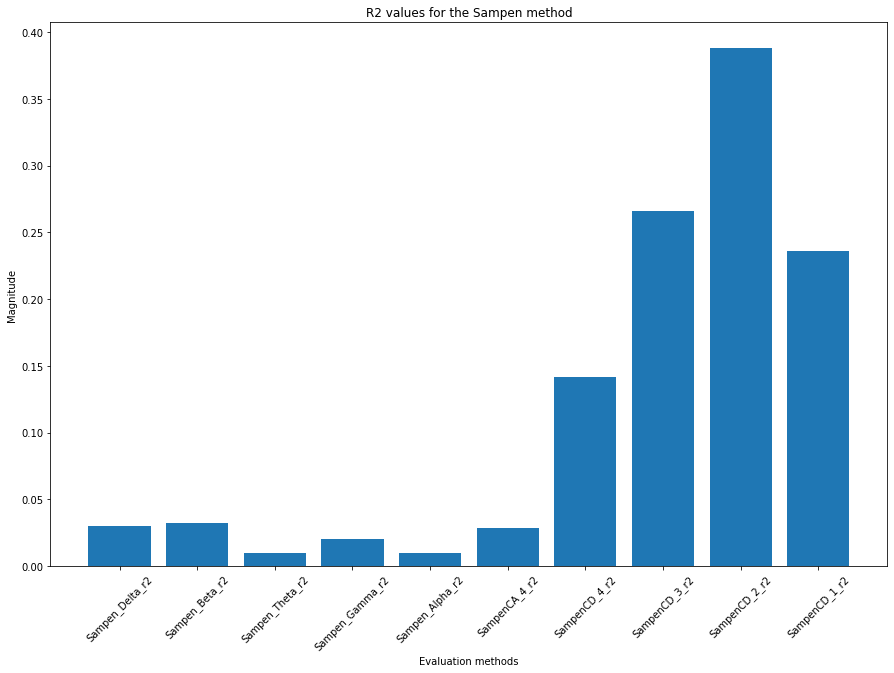

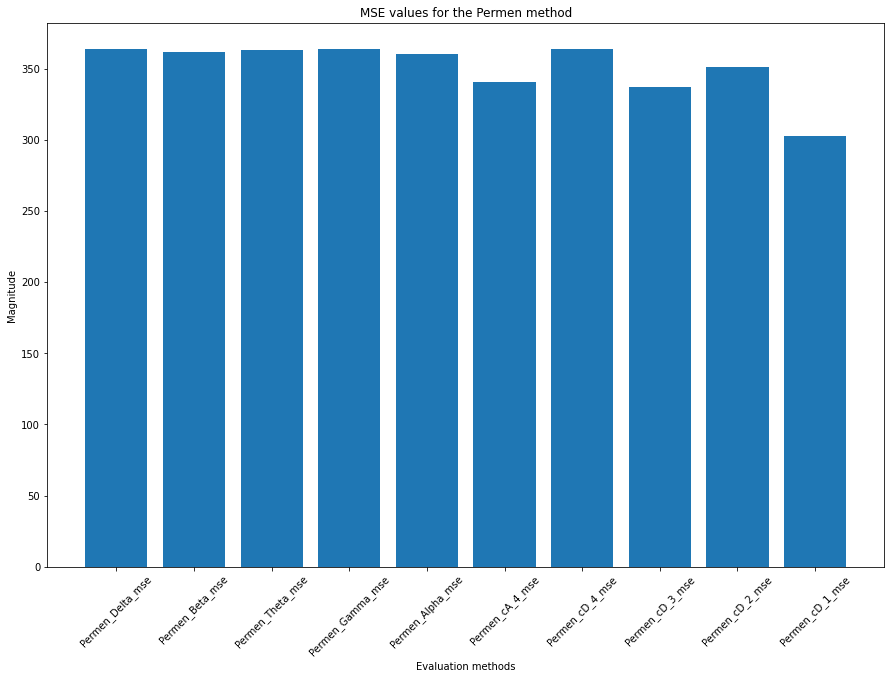

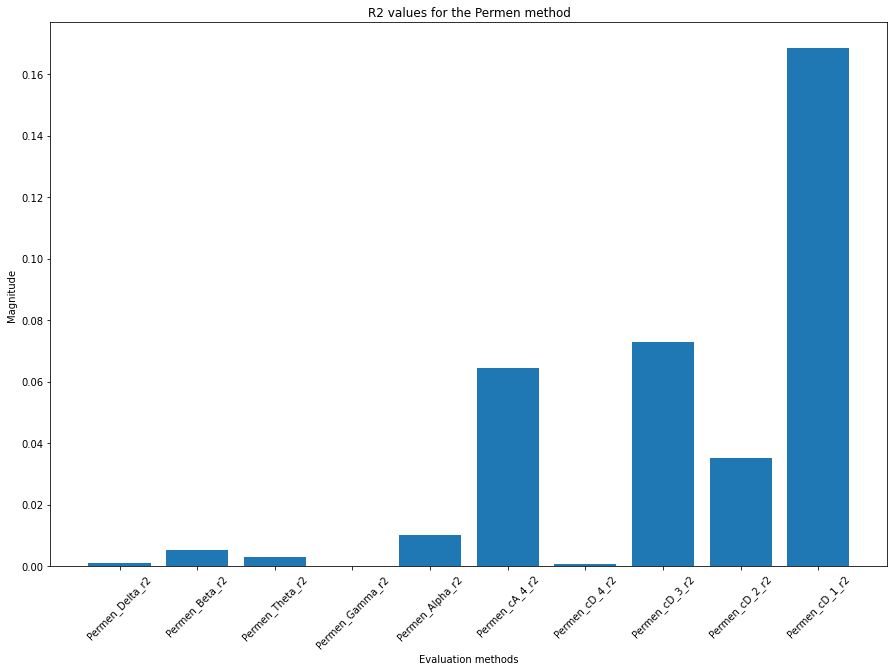

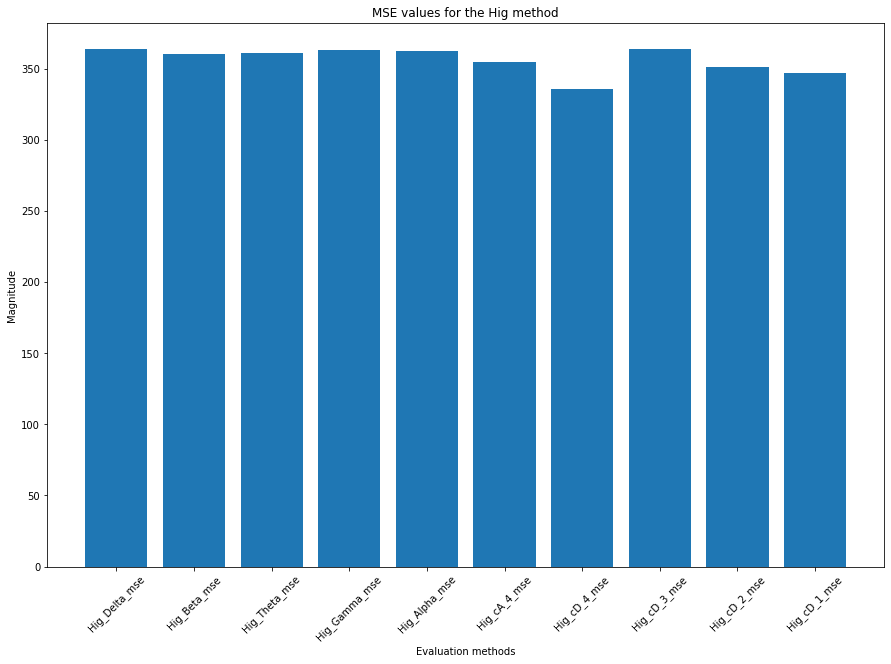

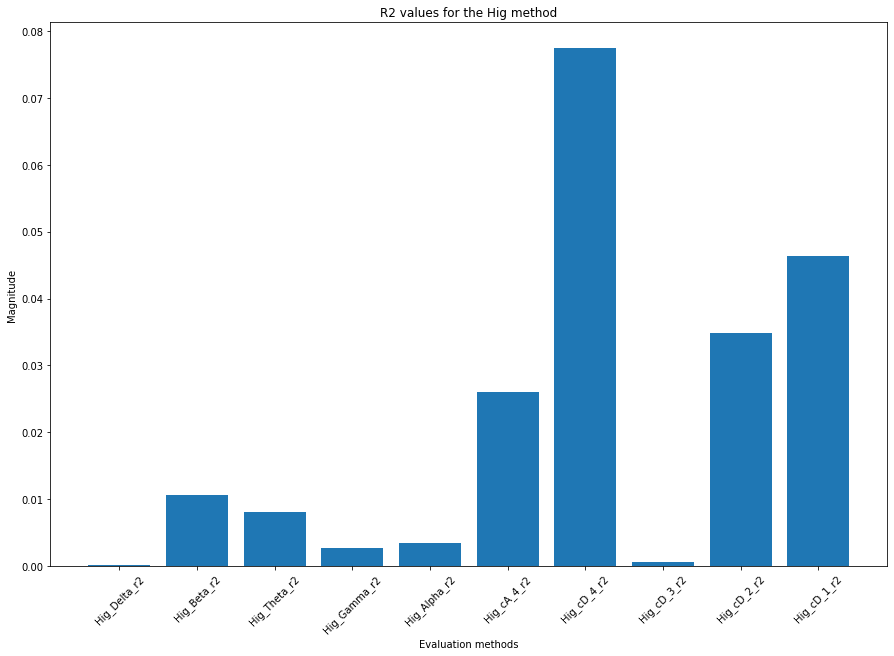

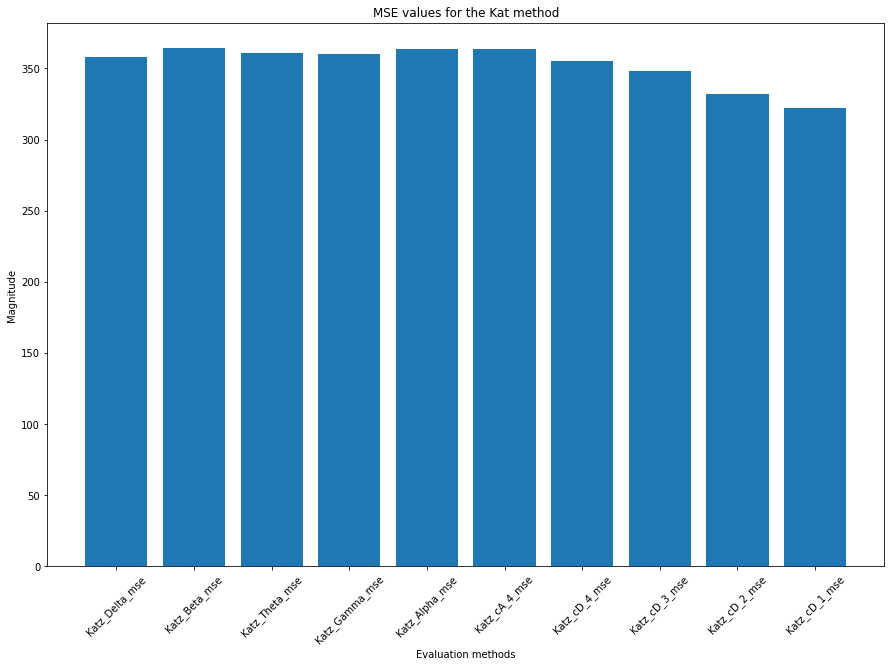

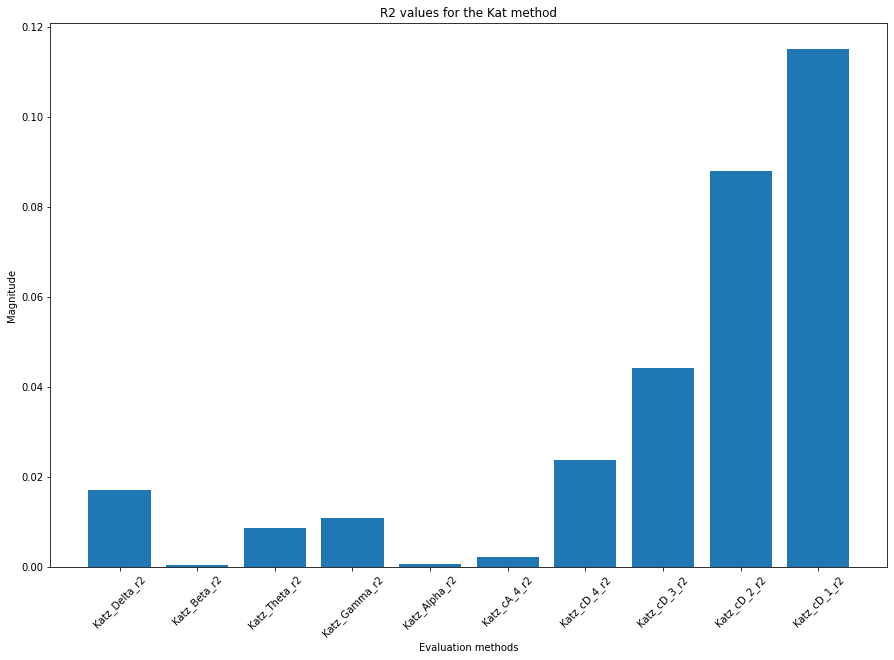

In [60]:
methods = ["Sampen", "Permen", "Hig", "Kat"]
ev_methods = ["mse", "r2"]

# Plotting MSE and r2 values for each method
for method in methods:
    err_metrics = metrics_df[metrics_df.Metrics.str.startswith(method)]
    
    for ev_method in ev_methods:
        ev = err_metrics[err_metrics.Metrics.str.endswith(ev_method)]
        
        # Plot the graphs
        fig = plt.figure(figsize=(15, 10))
        plt.bar(ev.Metrics, ev.Values)
        plt.xticks(rotation=45)
        plt.xlabel("Evaluation methods")
        plt.ylabel("Magnitude")    
        plt.title("{} values for the {} method".format(ev_method.upper(), method))        


In [5]:
ant.perm_entropy?

<br/>